<a href="https://colab.research.google.com/github/heschmidt/greatlakes-icecover-capstone/blob/main/capstone_notebook_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Codebook: The Influence of Teleconnections on Great Lake Ice Cover: Applications of Machine Learning



##### Load Libraries

In [ ]:
# Load Libraries
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import defaultdict
from scipy.stats import linregress
from scipy.stats import mode as stats_mode
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.utils import class_weight
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load and Pre-Process Data

In [ ]:
# Load Teleconnection Data

#NAO
monthly_nao_file = 'monthly_nao.xlsx'
monthly_nao = pd.read_excel(monthly_nao_file)
monthly_nao_long = monthly_nao.melt(id_vars='Year', var_name='Month', value_name='NAO')

#PNA
monthly_pna_file = 'pna_monthly.xlsx'
monthly_pna = pd.read_excel(monthly_pna_file)
monthly_pna_long = monthly_pna.melt(id_vars='Year', var_name='Month', value_name='PNA')

#ENSO
enso_file = 'monthly_multivar_enso.xlsx'
enso = pd.read_excel(enso_file)
monthly_enso_long = enso.melt(id_vars='Year', var_name='Month', value_name='ENSO')

#AO
ao_file = 'monthly_ao.xlsx'
ao = pd.read_excel(ao_file)
monthly_ao_long = ao.melt(id_vars='Year', var_name='Month', value_name='AO')

#TNH
tnh_file = 'tnh_index.xlsx'
tnh = pd.read_excel(tnh_file)
tnh['Month'] = tnh['Month'].apply(lambda x: calendar.month_abbr[x])
monthly_tnh_long = tnh

#PDO
pdo_file = 'monthly_pdo.xlsx'
pdo = pd.read_excel(pdo_file)
monthly_pdo_long = pdo.melt(id_vars='Year', var_name='Month', value_name='PDO')
monthly_pdo_long = monthly_pdo_long[monthly_pdo_long['PDO'] <= 3]

#AMO
amo_file = 'monthly_amo.xlsx'
amo = pd.read_excel(amo_file)
monthly_amo_long = amo.melt(id_vars='Year', var_name='Month', value_name='AMO')

# Format Months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_nao_long['Month'] = pd.Categorical(monthly_nao_long['Month'].astype(str), categories=month_order, ordered=True)
monthly_enso_long['Month'] = pd.Categorical(monthly_enso_long['Month'].astype(str), categories=month_order, ordered=True)
monthly_pdo_long['Month'] = pd.Categorical(monthly_pdo_long['Month'].astype(str), categories=month_order, ordered=True)
monthly_pna_long['Month'] = pd.Categorical(monthly_pna_long['Month'].astype(str), categories=month_order, ordered=True)
monthly_ao_long['Month'] = pd.Categorical(monthly_ao_long['Month'].astype(str), categories=month_order, ordered=True)
monthly_amo_long['Month'] = pd.Categorical(monthly_amo_long['Month'].astype(str), categories=month_order, ordered=True)
monthly_tnh_long['Month'] = pd.Categorical(monthly_tnh_long['Month'].astype(str), categories=month_order, ordered=True)

# Merge Teleconnections
def pivot_to_wide(df, index_name):
    df = df.copy()
    df['Month'] = df['Month'].astype(str).str.strip()
    df['Month'] = df['Month'].replace('nan', 'Jan')
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Month'], format='%Y%b')
    return df[['Date', index_name]]

# Convert to wide format
nao = pivot_to_wide(monthly_nao_long, 'NAO')
pna = pivot_to_wide(monthly_pna_long, 'PNA')
enso = pivot_to_wide(monthly_enso_long, 'ENSO')
ao = pivot_to_wide(monthly_ao_long, 'AO')
tnh = pivot_to_wide(monthly_tnh_long, 'TNH')
pdo = pivot_to_wide(monthly_pdo_long, 'PDO')
amo = pivot_to_wide(monthly_amo_long, 'AMO')

# Merge all into one df
df_tele = nao.merge(pna, on='Date') \
             .merge(enso, on='Date') \
             .merge(ao, on='Date') \
             .merge(tnh, on='Date') \
             .merge(pdo, on='Date') \
             .merge(amo, on='Date')

df_tele.drop_duplicates(subset=['Date'], keep='first', inplace=True)
df_tele['Date'] = pd.to_datetime(df_tele['Date'])
df_tele = df_tele.sort_values(by='Date').reset_index(drop=True)
df_tele['Year'] = df_tele['Date'].dt.year
df_tele['Month'] = df_tele['Date'].dt.month

df_tele['TNH'] = df_tele['TNH'].replace(-99.90, np.nan) # Values are set to -99.90 for calendar months when the patternis not normally a leading mode of variability

# Teleconnections list
indices = ['NAO', 'PNA', 'ENSO', 'AO', 'PDO', 'AMO', 'TNH']
features = ['NAO', 'PNA', 'ENSO', 'AO', 'PDO', 'AMO', 'TNH']

# Calculate winter averages for teleconnections
df_tele['WinterYear'] = np.where(df_tele['Month'] == 1, df_tele['Year'], df_tele['Year'] + 1)
winter_months = df_tele[df_tele['Month'].isin([11, 12, 1])]
winter_avg = winter_months.groupby('WinterYear')[
    ['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH']
].mean().reset_index().rename(columns={'WinterYear': 'Year'})


df_tele

Date   NAO   PNA  ENSO     AO   TNH   PDO    AMO  Year  Month  \
0   1979-01-01 -1.38 -0.69  0.47 -2.233  0.40 -0.38 -0.222  1979      1   
1   1979-02-01 -0.67 -1.82  0.29 -0.697 -0.57 -1.29 -0.220  1979      2   
2   1979-03-01  0.78  0.38 -0.05 -0.814   NaN -0.68 -0.219  1979      3   
3   1979-04-01 -1.71  0.09  0.21 -1.157   NaN -0.12 -0.217  1979      4   
4   1979-05-01 -1.03  1.35  0.27 -0.250   NaN  0.57 -0.214  1979      5   
..         ...   ...   ...   ...    ...   ...   ...    ...   ...    ...   
424 2017-07-01  1.26  1.86 -0.63  0.634   NaN -0.45  0.174  2017      7   
425 2017-08-01 -1.10  0.23 -0.73  0.150   NaN -0.63  0.174  2017      8   
426 2017-10-01  0.19 -0.40 -0.59  0.690   NaN -0.68  0.177  2017     10   
427 2017-11-01  0.00 -2.06 -0.62 -0.078   NaN -0.60  0.176  2017     11   
428 2017-12-01  0.88  0.89 -0.74 -0.059  1.04 -0.03  0.177  2017     12   

     WinterYear  
0          1979  
1          1980  
2          1980  
3          1980  
4          1980  
..          ...  
424        2018  
425        2018  
426        2018  
427        2018  
428        2018  

[429 rows x 11 columns]

In [ ]:
# Load Ice Data
def load_ice_data(file_path, lake_name):
    df = pd.read_excel(file_path)
    df_long = df.melt(id_vars='Date', var_name='Year', value_name=lake_name)
    df_long['Year'] = df_long['Year'].astype(int)
    df_long['Date'] = pd.to_datetime(df_long['Date'])
    df_long['Date'] = df_long.apply(lambda row: pd.Timestamp(year=row['Year'],month=row['Date'].month,day=row['Date'].day), axis=1)
    df_long['Date'] = df_long['Date'].dt.strftime('%m-%d-%Y')
    df_long = df_long.drop('Year', axis=1)
    return df_long

# Load and process data for each lake/basin
sup_long = load_ice_data('sup_icecover.xlsx', 'Superior')
mic_long = load_ice_data('mic_icecover.xlsx', 'Michigan')
hur_long = load_ice_data('hur_icecover.xlsx', 'Huron')
ont_long = load_ice_data('ont_icecover.xlsx', 'Ontario')
eri_long = load_ice_data('eri_icecover.xlsx', 'Erie')
basin_long = load_ice_data('basin_icecover.xlsx', 'Basin')

# Merge all lakes
ice_cover_df = sup_long.merge(mic_long, on=['Date'], how='outer') \
                    .merge(hur_long, on=['Date'], how='outer') \
                    .merge(ont_long, on=['Date'], how='outer') \
                    .merge(eri_long, on=['Date'], how='outer') \
                    .merge(basin_long, on=['Date'], how='outer')

# Format Date
ice_cover_df['Date'] = pd.to_datetime(ice_cover_df['Date'])
ice_cover_df = ice_cover_df.sort_values(by='Date').reset_index(drop=True)
ice_cover_df['Year'] = ice_cover_df['Date'].dt.year
ice_cover_df['Month'] = ice_cover_df['Date'].dt.month

# Create Season Column
ice_cover_df['Season'] = ice_cover_df['Date'].apply(lambda d: f"{d.year}-{d.year + 1}" if d.month >= 10 else f"{d.year - 1}-{d.year}")

# Lake list
lakes = ['Superior', 'Michigan', 'Huron', 'Ontario', 'Erie', 'Basin']
lake = ['Superior', 'Michigan', 'Huron', 'Ontario', 'Erie', 'Basin']

ice_cover_df

Date  Superior  Michigan  Huron  Ontario  Erie  Basin  Year  \
0     1973-01-01      12.2       7.4   19.3      2.7   2.7   11.1  1973   
1     1973-01-02      12.9       6.3   21.1      2.7   3.4   11.5  1973   
2     1973-01-03      15.5       8.6   22.5      5.6   6.7   13.9  1973   
3     1973-01-04      17.4      10.1   23.7      7.7   9.5   15.6  1973   
4     1973-01-05      20.0      12.4   25.1     10.5  12.8   18.0  1973   
...          ...       ...       ...    ...      ...   ...    ...   ...   
14087 2024-12-27       0.5       0.0    0.0      0.0   0.0    0.2  2024   
14088 2024-12-28       0.5       0.0    0.0      0.0   0.0    0.2  2024   
14089 2024-12-29       0.5       0.0    0.0      0.0   0.0    0.2  2024   
14090 2024-12-30       0.5       0.0    0.0      0.0   0.0    0.2  2024   
14091 2024-12-31       0.4       0.0    0.0      0.0   0.0    0.2  2024   

       Month     Season  
0          1  1972-1973  
1          1  1972-1973  
2          1  1972-1973  
3          1  1972-1973  
4          1  1972-1973  
...      ...        ...  
14087     12  2024-2025  
14088     12  2024-2025  
14089     12  2024-2025  
14090     12  2024-2025  
14091     12  2024-2025  

[14092 rows x 10 columns]

### Determine Duration Classes

count    318.000000
mean      91.682390
std       30.537918
min        0.000000
25%       77.000000
50%       99.000000
75%      112.000000
max      149.000000
dtype: float64


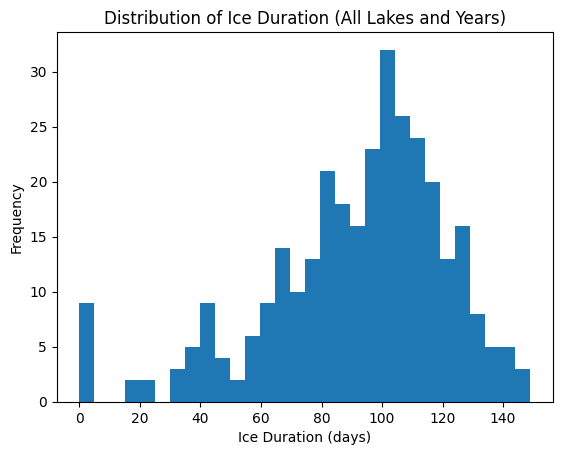

In [ ]:
# Covert to long
long_df = ice_cover_df.melt(
    id_vars=['Date', 'Year', 'Season', 'Month'],
    value_vars=lakes,
    var_name='Lake',
    value_name='IceCover')

# Initialize durations list
all_durations = []

# Loop through all lakes
for lake in lakes:
    lake_df = long_df[long_df['Lake'] == lake].copy()
    lake_df['IceCover'] = lake_df['IceCover'].fillna(0)

    lake_df['Season'] = lake_df['Date'].apply(
        lambda d: f"{d.year}-{d.year + 1}" if d.month >= 10 else f"{d.year - 1}-{d.year}"
    )

    durations = (
        lake_df.groupby('Season')
        .apply(lambda g: (g[g['IceCover'] >= 5]['Date'].max() - g[g['IceCover'] >= 5]['Date'].min()).days + 1
                      if not g[g['IceCover'] >= 5].empty else 0)
        .reset_index(name='ice_duration_days')
    )

    all_durations.extend(durations['ice_duration_days'].tolist())

all_durations = pd.Series(all_durations)

# View Duration distribution and stats
print(all_durations.describe())
plt.hist(all_durations, bins=30)
plt.xlabel("Ice Duration (days)")
plt.ylabel("Frequency")
plt.title("Distribution of Ice Duration (All Lakes and Years)")
plt.show()

In [ ]:
# Classify Duration based on 25% and 75% quartiles
def classify_duration(days):
    if days <= 76:
        return 'Short'
    elif days <= 112:
        return 'Medium'
    else:
        return 'Long'

### Initial Visualizations

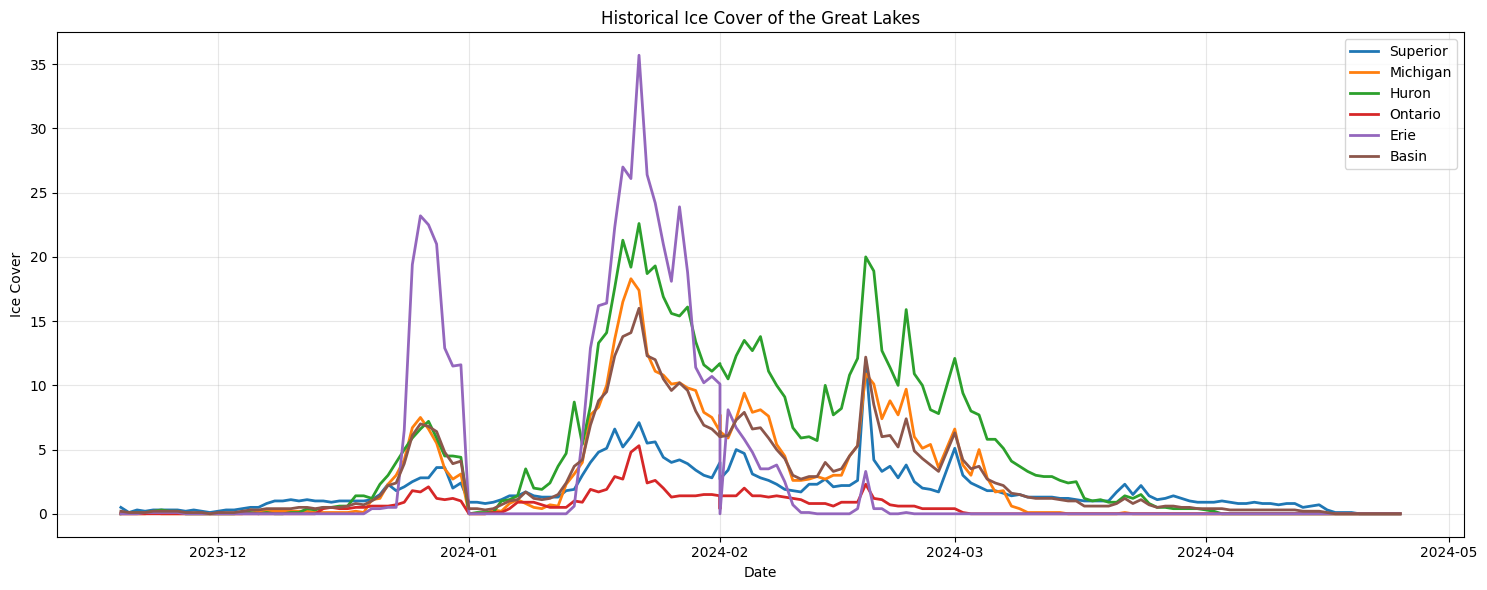

In [ ]:
# Historical Ice Cover Plot

# Date range
# Set dates as needed
ice_cover_crop = ice_cover_df[
    (ice_cover_df['Date'] >= '2023-10-01') &
    (ice_cover_df['Date'] <= '2024-04-30')]

# Plot time series
plt.figure(figsize=(15, 6))
for lake in lakes:
    plt.plot(ice_cover_crop['Date'], ice_cover_crop[lake], label=lake, linestyle='-', linewidth=2)
plt.title('Historical Ice Cover of the Great Lakes')
plt.xlabel('Date')
plt.ylabel('Ice Cover')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

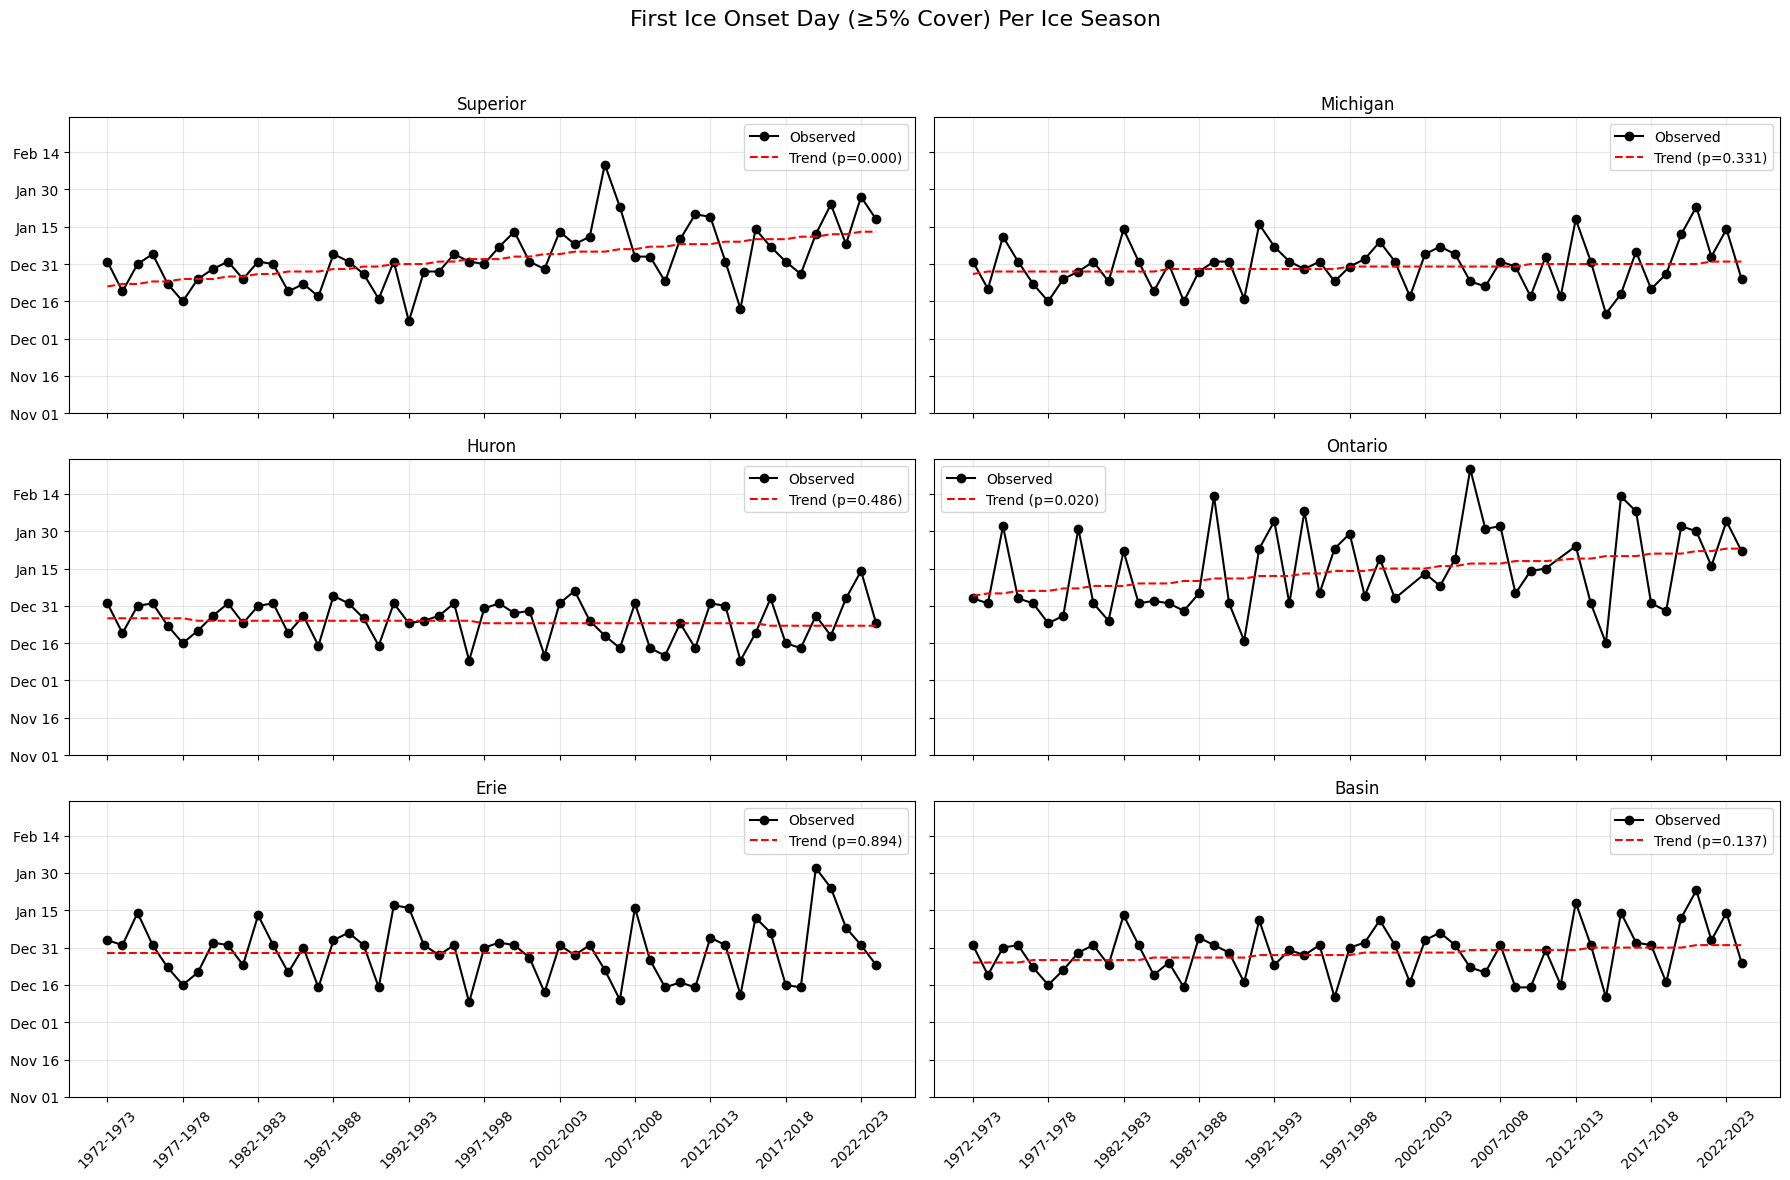

In [ ]:
# First Onset Day per Season Plot

# Normalize onset dates (Oct–Apr) function
def normalize_date_to_ice_season(date):
    year = 2000 if date.month >= 10 else 2001
    return date.replace(year=year)

# Plot
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, lake in enumerate(lakes):

    # First onset date for each ice season
    lake_data = ice_cover_df[ice_cover_df[lake] >= 5].copy()
    lake_data['Season'] = lake_data['Date'].apply(
        lambda d: f"{d.year}-{d.year + 1}" if d.month >= 10 else f"{d.year - 1}-{d.year}")

    lake_onsets = (
        lake_data.sort_values('Date')
        .groupby('Season')
        .first()
        .reset_index()[['Season', 'Date']]
    )
    lake_onsets['Normalized'] = lake_onsets['Date'].apply(normalize_date_to_ice_season)

    # Prepare X and y
    X = np.arange(len(lake_onsets))
    y_ord = lake_onsets['Normalized'].map(datetime.toordinal).values

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(X, y_ord)
    y_pred_ord = intercept + slope * X
    y_pred_dates = [datetime.fromordinal(int(d)) for d in y_pred_ord]

    # Plot
    ax = axes[i]
    ax.plot(lake_onsets['Season'], lake_onsets['Normalized'], marker='o', color='black', label='Observed')
    ax.plot(lake_onsets['Season'], y_pred_dates, color='red', linestyle='--', label=f'Trend (p={p_value:.3f})')
    ax.set_title(f"{lake}", fontsize=12)
    start = datetime(2000, 11, 1)
    end = datetime(2001, 2, 28)
    ticks = pd.date_range(start=start, end=end, freq='15D')
    ax.set_ylim(start, end)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True, alpha=0.3)
    ax.legend()

    # X-axis - 5 year ticks
    season_labels = lake_onsets['Season'].tolist()
    xtick_positions = np.arange(len(season_labels))
    ax.set_xticks(xtick_positions[::5])
    ax.set_xticklabels(season_labels[::5], rotation=45)

# Remove empty subplots
for j in range(len(lakes), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("First Ice Onset Day (≥5% Cover) Per Ice Season", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


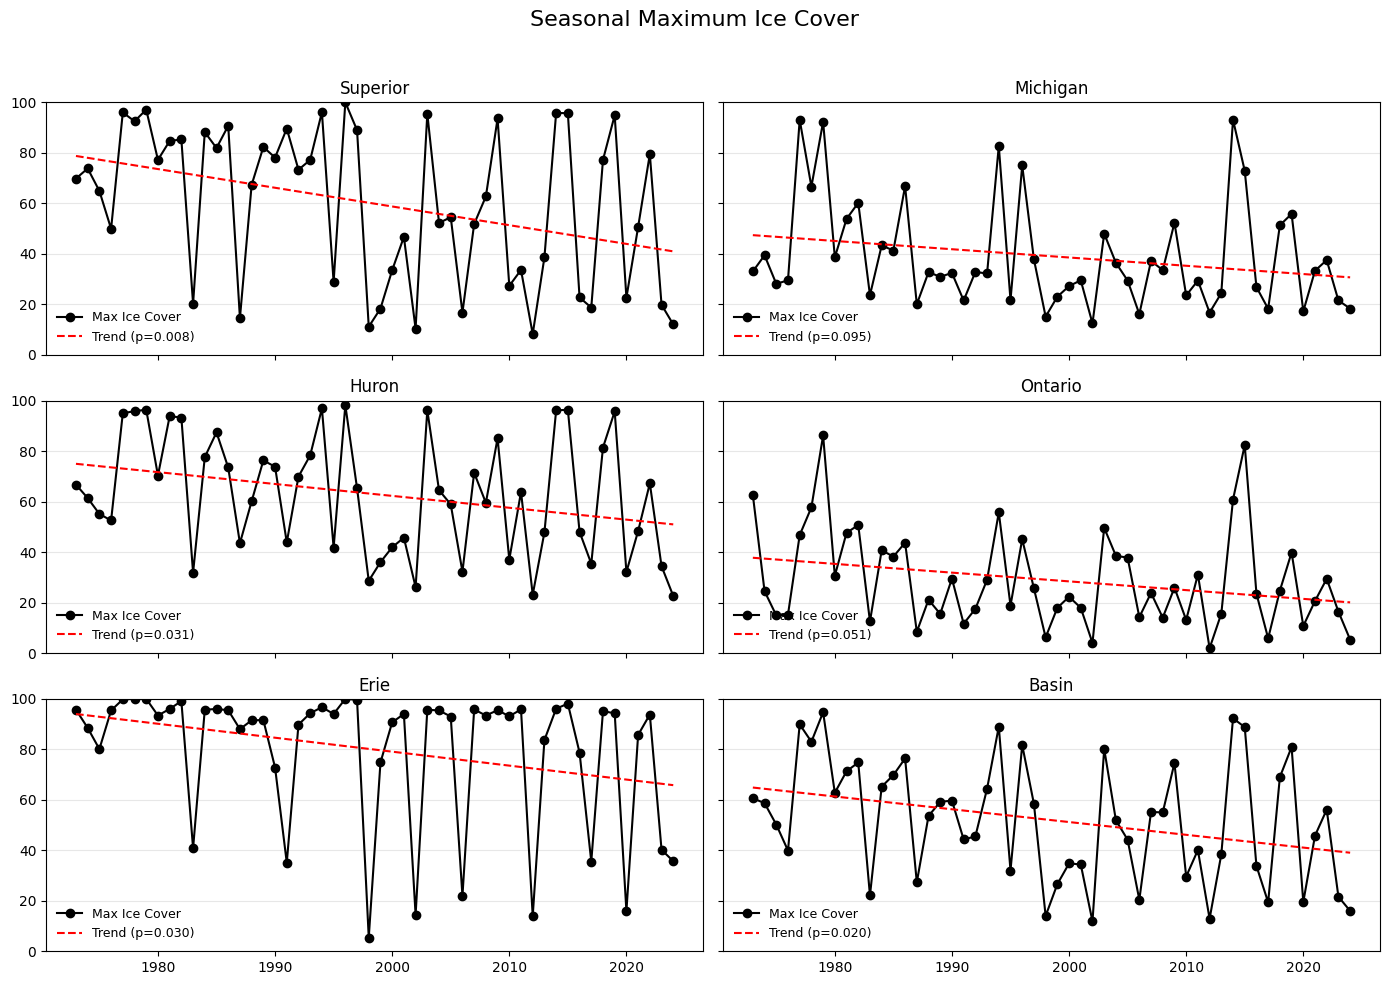

In [ ]:
# Historical Maximum Ice Cover Plot

ice_cover_df['Year'] = ice_cover_df['Date'].dt.year

fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=False)
fig.suptitle("Seasonal Maximum Ice Cover", fontsize=16)
axes = axes.flatten()

# Loop through lakes
for i, lake in enumerate(lakes):
    ax = axes[i]
    max_ice = ice_cover_df.groupby('Year')[lake].max()

    # Plot observed
    ax.plot(max_ice.index, max_ice.values, marker='o', label='Max Ice Cover', color='black')

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(max_ice.index, max_ice.values)
    trendline = intercept + slope * max_ice.index

    # Plot trendline
    ax.plot(max_ice.index, trendline, 'r--', linewidth=1.5, label=f'Trend (p={p_value:.3f})')

    ax.set_title(lake, fontsize=12, color='black')
    ax.set_yticks([0, 20, 40, 60, 80, 100])
    ax.set_ylim(0, 100)
    ax.grid(True, which='major', axis='y', alpha=0.3)

    if i not in [4, 5]:
        ax.set_xticklabels([])
    if i % 2 == 1:
        ax.set_ylabel('')
        ax.set_yticklabels([])

    ax.legend(loc='lower left', fontsize=9, frameon=False)

# Remove empty axes
for j in range(len(lakes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


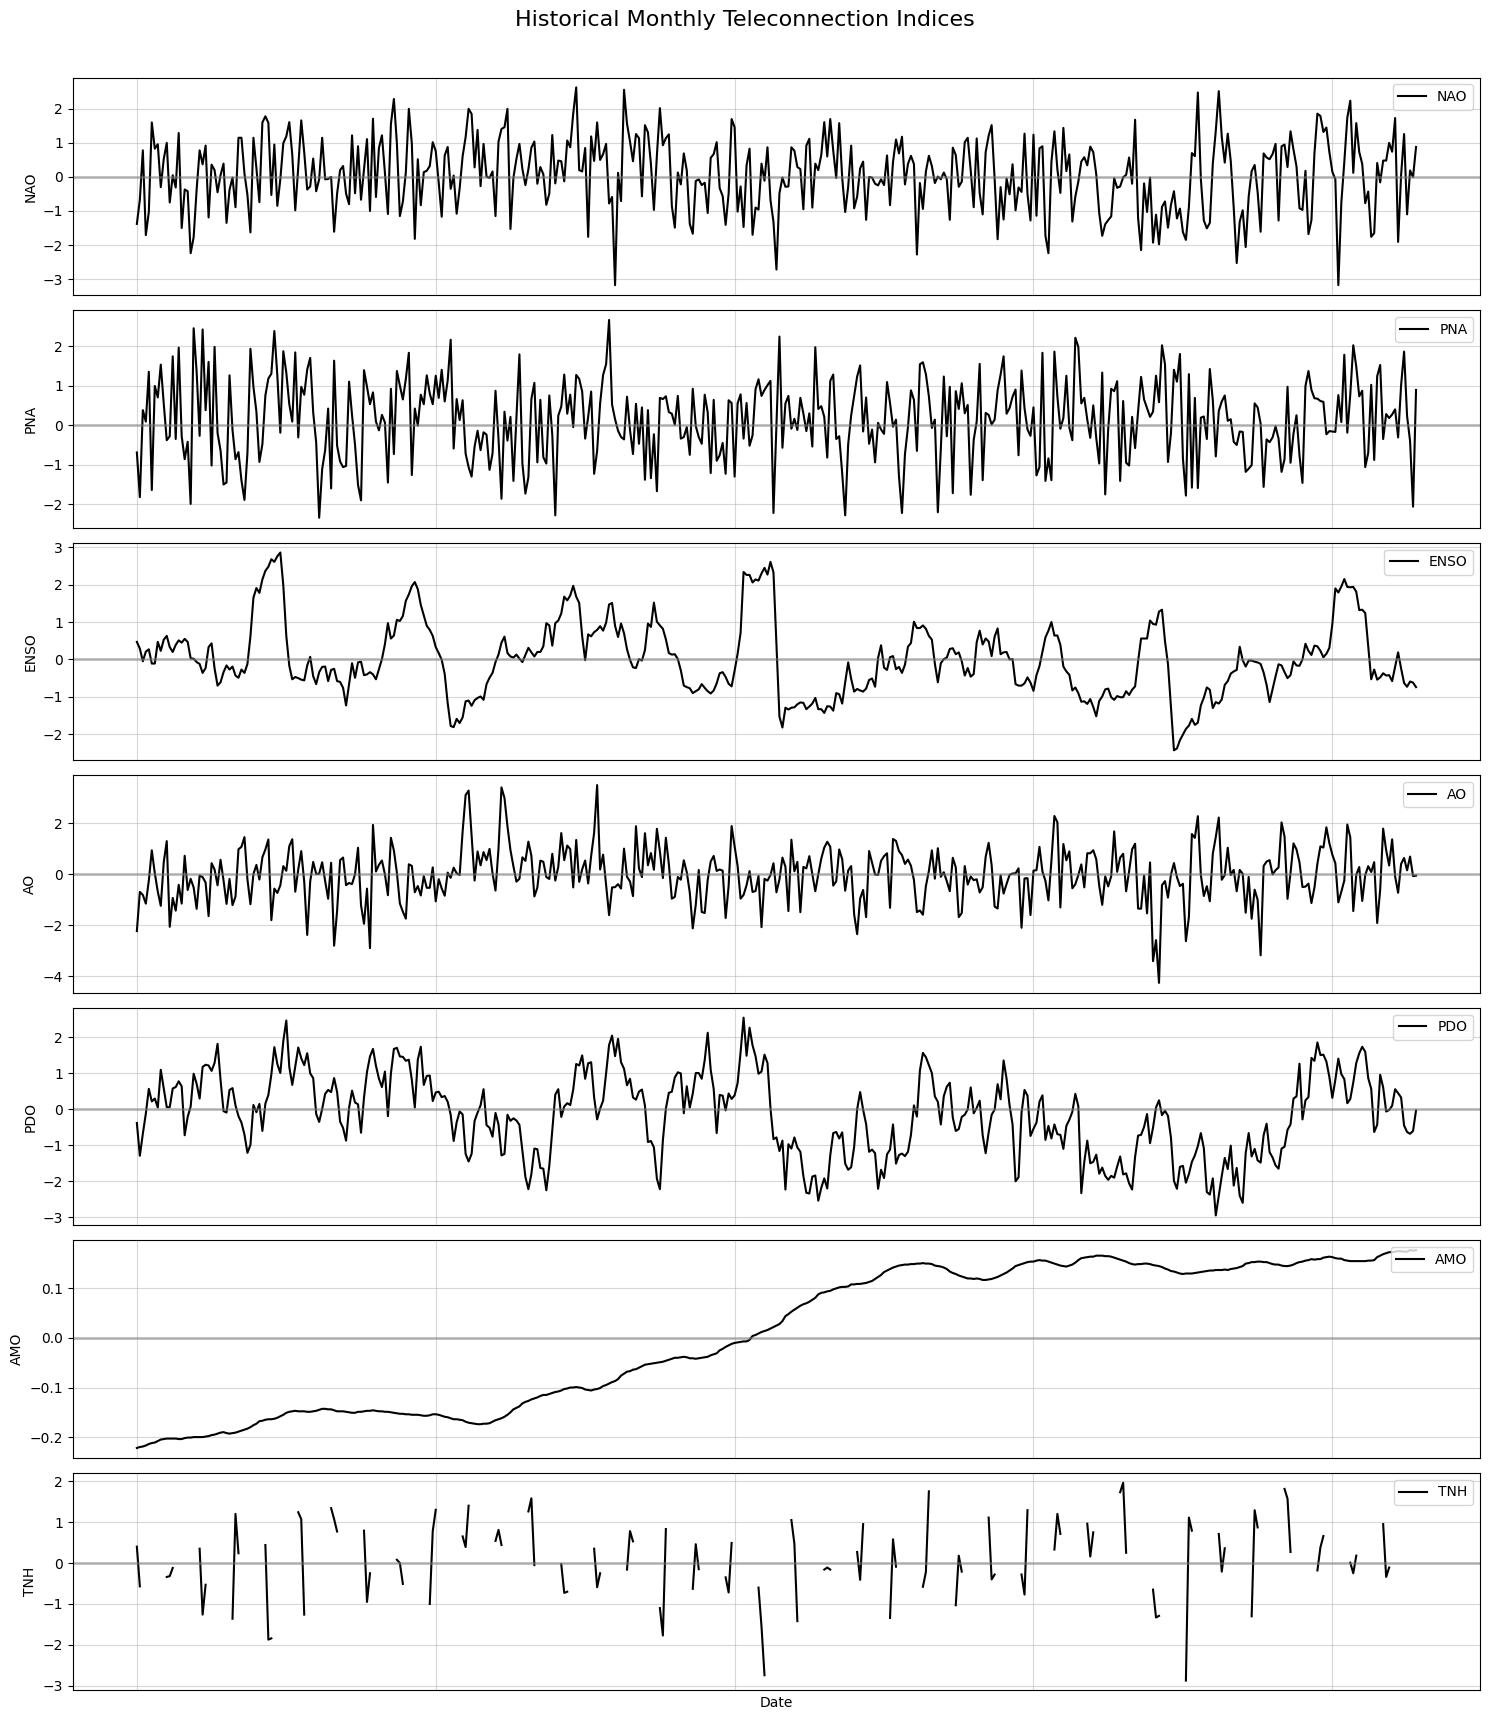

In [ ]:
# Historical Teleconnections Plot
fig, axes = plt.subplots(nrows=len(indices), ncols=1, figsize=(15, 2.5 * len(indices)))

# Plot all teleconnection idices
for ax, index in zip(axes, indices):
    ax.plot(df_tele.index, df_tele[index], label=index, color='black', linewidth=1.5)
    ax.axhline(0, color='grey', linewidth=2, alpha = 0.5)
    ax.set_ylabel(index)
    ax.grid(True, alpha=0.5)
    ax.legend(loc='upper right')
    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

plt.xlabel('Date')
plt.suptitle('Historical Monthly Teleconnection Indices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

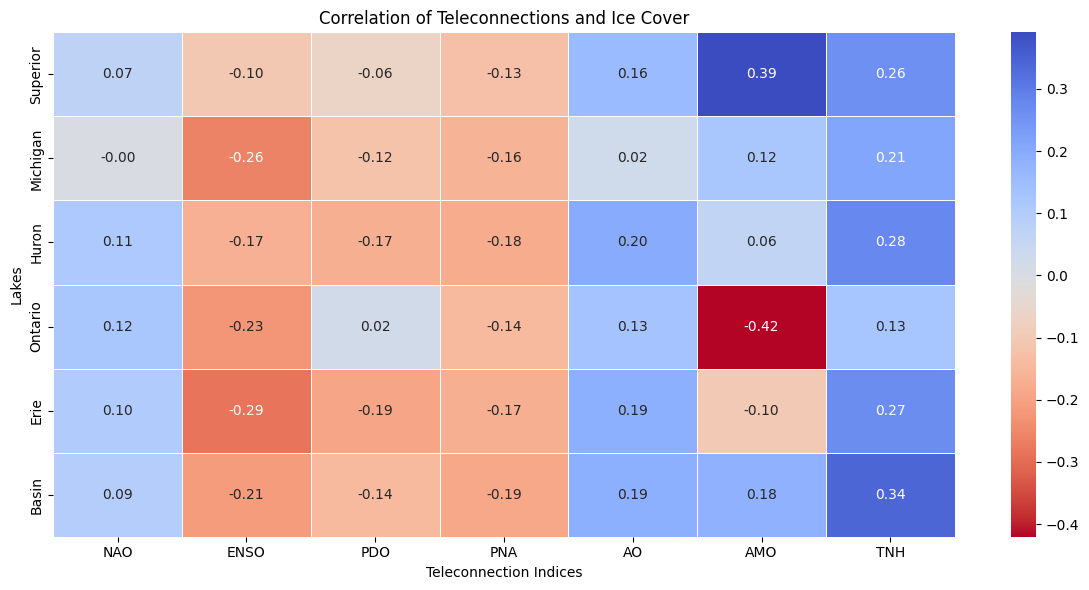

In [ ]:
# Ice Cover - Teleconnections Correlation Heat Map

# Create correlation matrix between each lake and teleconnection
correlation_matrix = pd.DataFrame({
    "NAO": [df_tele['NAO'].corr(ice_cover_df[lake]) for lake in lakes],
    "ENSO": [df_tele['ENSO'].corr(ice_cover_df[lake]) for lake in lakes],
    "PDO": [df_tele['PDO'].corr(ice_cover_df[lake]) for lake in lakes],
    "PNA": [df_tele['PNA'].corr(ice_cover_df[lake]) for lake in lakes],
    "AO": [df_tele['AO'].corr(ice_cover_df[lake]) for lake in lakes],
    "AMO": [df_tele['AMO'].corr(ice_cover_df[lake]) for lake in lakes],
    "TNH": [df_tele['TNH'].corr(ice_cover_df[lake]) for lake in lakes]
}, index=lakes)

# Plot correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm_r", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Teleconnections and Ice Cover")
plt.xlabel("Teleconnection Indices")
plt.ylabel("Lakes")
plt.tight_layout()
plt.show()

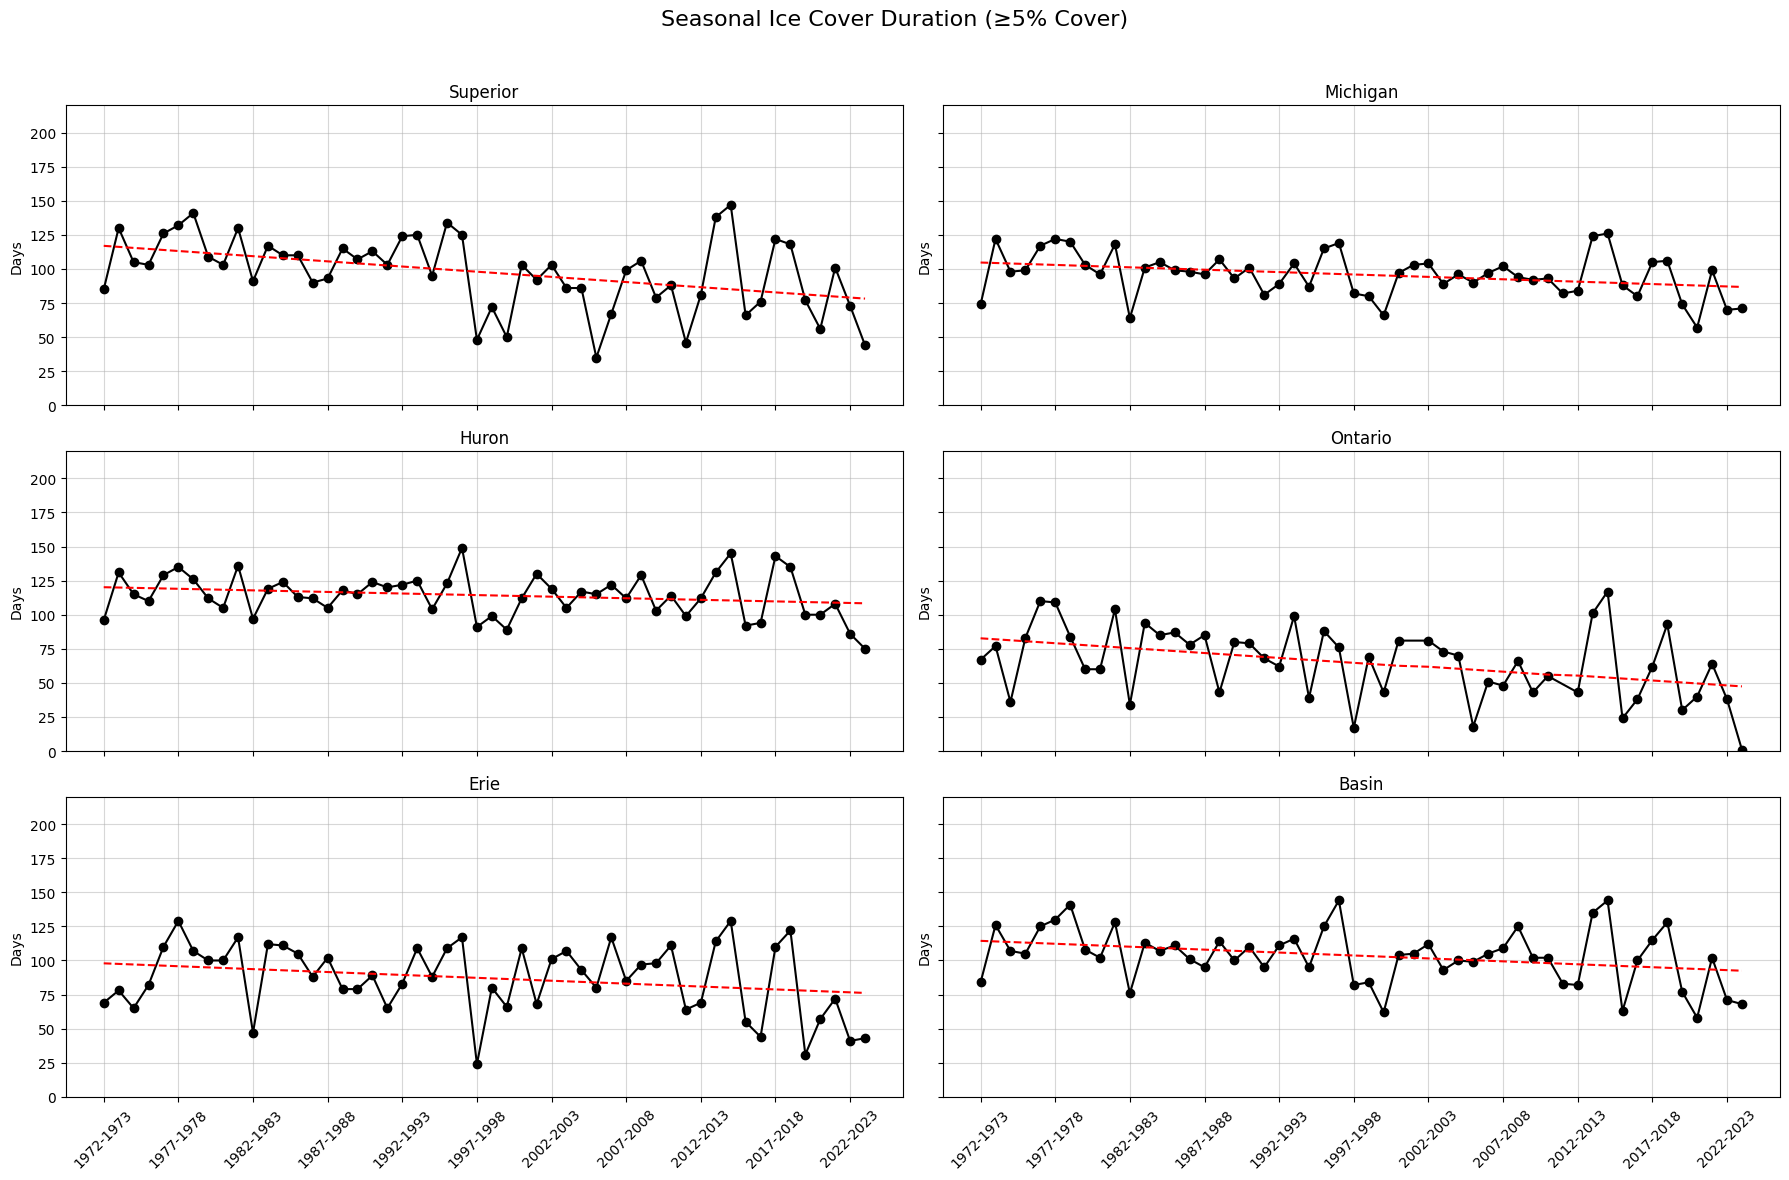

In [ ]:
# Ice Cover Duration Time Series

# Plot
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True, sharey=True)
fig.suptitle("Seasonal Ice Cover Duration (≥5% Cover)", fontsize=16)
axes = axes.flatten()

# Loop through lakes
for i, lake in enumerate(lakes):
    ax = axes[i]

    # Filter for lake and get first and last day per season with ice cover ≥5%
    lake_data = ice_cover_df[['Date', 'Season', lake]].copy()
    lake_data = lake_data[lake_data[lake] >= 5]

    # Group by season and calculate duration
    durations = (
        lake_data.groupby('Season')['Date']
        .agg(lambda x: (x.max() - x.min()).days + 1)
        .reset_index()
        .rename(columns={'Date': 'Duration'}))

    # Plot
    ax.plot(durations['Season'], durations['Duration'], marker='o', color='black')

    # Trend line
    X = np.arange(len(durations)).reshape(-1, 1)
    y = durations['Duration'].values.reshape(-1, 1)
    z = np.polyfit(X.flatten(), y.flatten(), 1)
    p = np.poly1d(z)
    ax.plot(durations['Season'], p(X).flatten(), 'r--', label='Trend')

    ax.set_title(lake, fontsize=12)

    # Y-axis
    ax.set_ylabel("Days")
    ax.set_ylim(0, 220)
    ax.grid(True, alpha=0.5)

    # X-axis - 5 year ticks
    season_labels = lake_onsets['Season'].tolist()
    xtick_positions = np.arange(len(season_labels))
    ax.set_xticks(xtick_positions[::5])
    ax.set_xticklabels(season_labels[::5], rotation=45)

for j in range(len(lakes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Random Forests


 Training Random Forest for Superior — Mode: precise
              precision    recall  f1-score   support

           0      0.993     1.000     0.997      1779
           1      0.000     0.000     0.000        12

    accuracy                          0.993      1791
   macro avg      0.497     0.500     0.498      1791
weighted avg      0.987     0.993     0.990      1791


 Classification Report for Superior – precise


precision  recall  f1-score   support
0                 0.993   1.000     0.997  1779.000
1                 0.000   0.000     0.000    12.000
accuracy          0.993   0.993     0.993     0.993
macro avg         0.497   0.500     0.498  1791.000
weighted avg      0.987   0.993     0.990  1791.000


 5-Fold Cross-Validation (F1 Score) for Superior – precise:
Mean F1: 0.000 ± 0.000


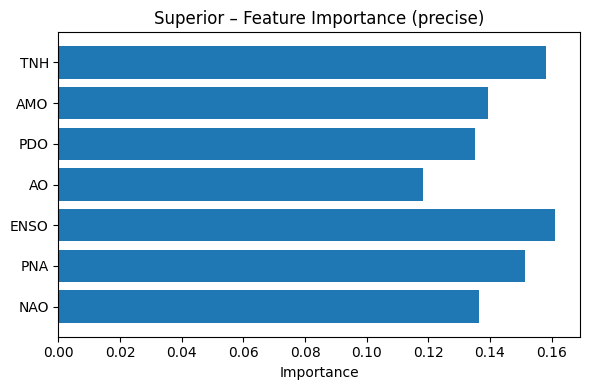


 Training Random Forest for Superior — Mode: 5day
              precision    recall  f1-score   support

           0      0.967     1.000     0.983      1732
           1      0.000     0.000     0.000        59

    accuracy                          0.967      1791
   macro avg      0.484     0.500     0.492      1791
weighted avg      0.935     0.967     0.951      1791


 Classification Report for Superior – 5day


precision  recall  f1-score   support
0                 0.967   1.000     0.983  1732.000
1                 0.000   0.000     0.000    59.000
accuracy          0.967   0.967     0.967     0.967
macro avg         0.484   0.500     0.492  1791.000
weighted avg      0.935   0.967     0.951  1791.000


 5-Fold Cross-Validation (F1 Score) for Superior – 5day:
Mean F1: 0.047 ± 0.047


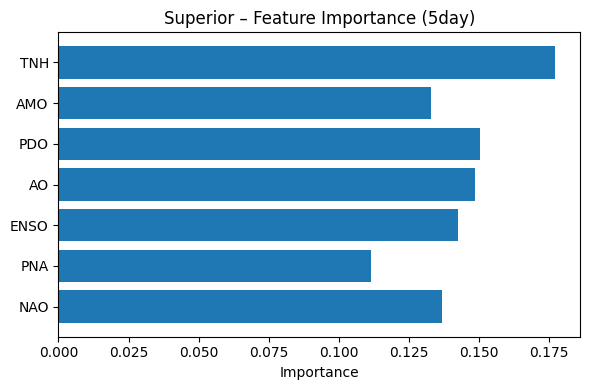


 Training Random Forest for Superior — Mode: 10day
              precision    recall  f1-score   support

           0      0.935     1.000     0.966      1674
           1      0.000     0.000     0.000       117

    accuracy                          0.935      1791
   macro avg      0.467     0.500     0.483      1791
weighted avg      0.874     0.935     0.903      1791


 Classification Report for Superior – 10day


precision  recall  f1-score   support
0                 0.935   1.000     0.966  1674.000
1                 0.000   0.000     0.000   117.000
accuracy          0.935   0.935     0.935     0.935
macro avg         0.467   0.500     0.483  1791.000
weighted avg      0.874   0.935     0.903  1791.000


 5-Fold Cross-Validation (F1 Score) for Superior – 10day:
Mean F1: 0.061 ± 0.061


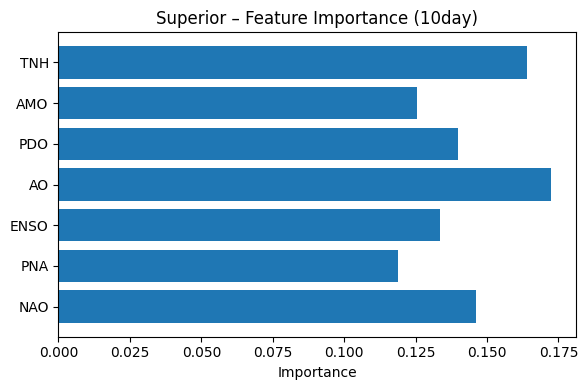


 Training Random Forest for Michigan — Mode: precise
              precision    recall  f1-score   support

           0      0.993     1.000     0.997      1779
           1      0.000     0.000     0.000        12

    accuracy                          0.993      1791
   macro avg      0.497     0.500     0.498      1791
weighted avg      0.987     0.993     0.990      1791


 Classification Report for Michigan – precise


precision  recall  f1-score   support
0                 0.993   1.000     0.997  1779.000
1                 0.000   0.000     0.000    12.000
accuracy          0.993   0.993     0.993     0.993
macro avg         0.497   0.500     0.498  1791.000
weighted avg      0.987   0.993     0.990  1791.000


 5-Fold Cross-Validation (F1 Score) for Michigan – precise:
Mean F1: 0.000 ± 0.000


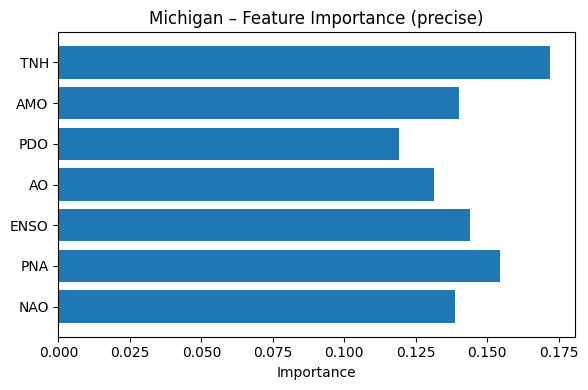


 Training Random Forest for Michigan — Mode: 5day
              precision    recall  f1-score   support

           0      0.967     1.000     0.983      1732
           1      0.000     0.000     0.000        59

    accuracy                          0.967      1791
   macro avg      0.484     0.500     0.492      1791
weighted avg      0.935     0.967     0.951      1791


 Classification Report for Michigan – 5day


precision  recall  f1-score   support
0                 0.967   1.000     0.983  1732.000
1                 0.000   0.000     0.000    59.000
accuracy          0.967   0.967     0.967     0.967
macro avg         0.484   0.500     0.492  1791.000
weighted avg      0.935   0.967     0.951  1791.000


 5-Fold Cross-Validation (F1 Score) for Michigan – 5day:
Mean F1: 0.047 ± 0.047


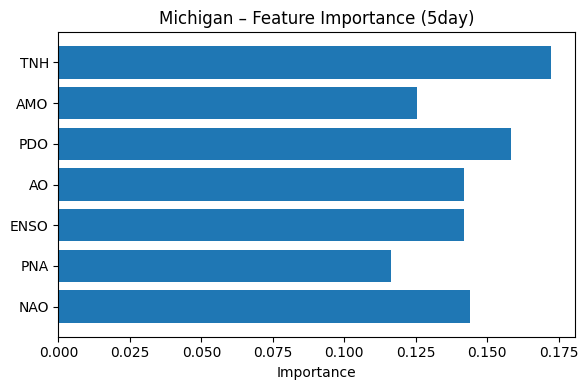


 Training Random Forest for Michigan — Mode: 10day
              precision    recall  f1-score   support

           0      0.935     1.000     0.966      1674
           1      0.000     0.000     0.000       117

    accuracy                          0.935      1791
   macro avg      0.467     0.500     0.483      1791
weighted avg      0.874     0.935     0.903      1791


 Classification Report for Michigan – 10day


precision  recall  f1-score   support
0                 0.935   1.000     0.966  1674.000
1                 0.000   0.000     0.000   117.000
accuracy          0.935   0.935     0.935     0.935
macro avg         0.467   0.500     0.483  1791.000
weighted avg      0.874   0.935     0.903  1791.000


 5-Fold Cross-Validation (F1 Score) for Michigan – 10day:
Mean F1: 0.061 ± 0.061


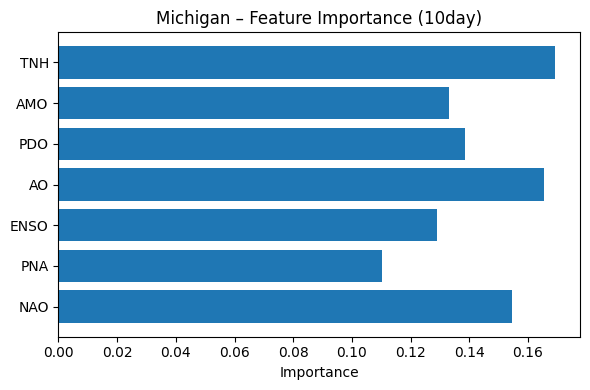


 Training Random Forest for Huron — Mode: precise
              precision    recall  f1-score   support

           0      0.993     1.000     0.997      1779
           1      0.000     0.000     0.000        12

    accuracy                          0.993      1791
   macro avg      0.497     0.500     0.498      1791
weighted avg      0.987     0.993     0.990      1791


 Classification Report for Huron – precise


precision  recall  f1-score   support
0                 0.993   1.000     0.997  1779.000
1                 0.000   0.000     0.000    12.000
accuracy          0.993   0.993     0.993     0.993
macro avg         0.497   0.500     0.498  1791.000
weighted avg      0.987   0.993     0.990  1791.000


 5-Fold Cross-Validation (F1 Score) for Huron – precise:
Mean F1: 0.000 ± 0.000


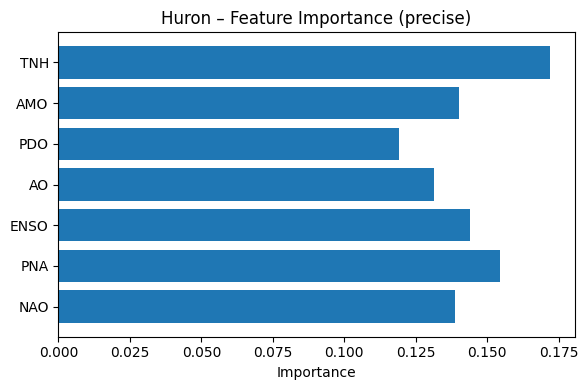


 Training Random Forest for Huron — Mode: 5day
              precision    recall  f1-score   support

           0      0.967     1.000     0.983      1732
           1      0.000     0.000     0.000        59

    accuracy                          0.967      1791
   macro avg      0.484     0.500     0.492      1791
weighted avg      0.935     0.967     0.951      1791


 Classification Report for Huron – 5day


precision  recall  f1-score   support
0                 0.967   1.000     0.983  1732.000
1                 0.000   0.000     0.000    59.000
accuracy          0.967   0.967     0.967     0.967
macro avg         0.484   0.500     0.492  1791.000
weighted avg      0.935   0.967     0.951  1791.000


 5-Fold Cross-Validation (F1 Score) for Huron – 5day:
Mean F1: 0.059 ± 0.041


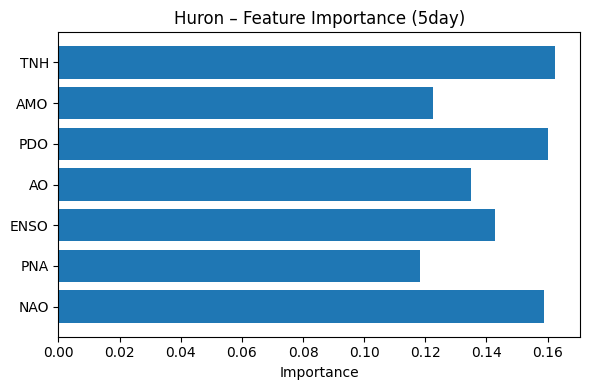


 Training Random Forest for Huron — Mode: 10day
              precision    recall  f1-score   support

           0      0.935     1.000     0.966      1674
           1      0.000     0.000     0.000       117

    accuracy                          0.935      1791
   macro avg      0.467     0.500     0.483      1791
weighted avg      0.874     0.935     0.903      1791


 Classification Report for Huron – 10day


precision  recall  f1-score   support
0                 0.935   1.000     0.966  1674.000
1                 0.000   0.000     0.000   117.000
accuracy          0.935   0.935     0.935     0.935
macro avg         0.467   0.500     0.483  1791.000
weighted avg      0.874   0.935     0.903  1791.000


 5-Fold Cross-Validation (F1 Score) for Huron – 10day:
Mean F1: 0.076 ± 0.053


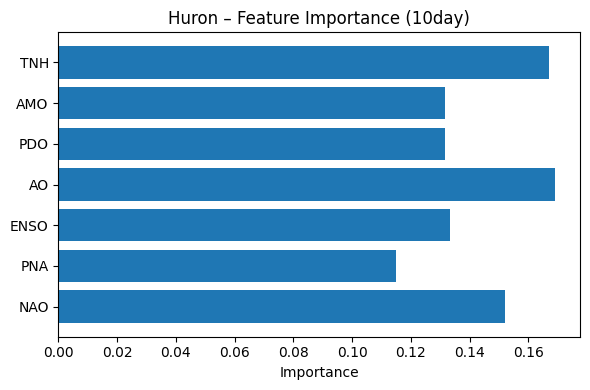


 Training Random Forest for Ontario — Mode: precise
              precision    recall  f1-score   support

           0      0.994     1.000     0.997      1780
           1      0.000     0.000     0.000        11

    accuracy                          0.994      1791
   macro avg      0.497     0.500     0.498      1791
weighted avg      0.988     0.994     0.991      1791


 Classification Report for Ontario – precise


precision  recall  f1-score   support
0                 0.994   1.000     0.997  1780.000
1                 0.000   0.000     0.000    11.000
accuracy          0.994   0.994     0.994     0.994
macro avg         0.497   0.500     0.498  1791.000
weighted avg      0.988   0.994     0.991  1791.000


 5-Fold Cross-Validation (F1 Score) for Ontario – precise:
Mean F1: 0.000 ± 0.000


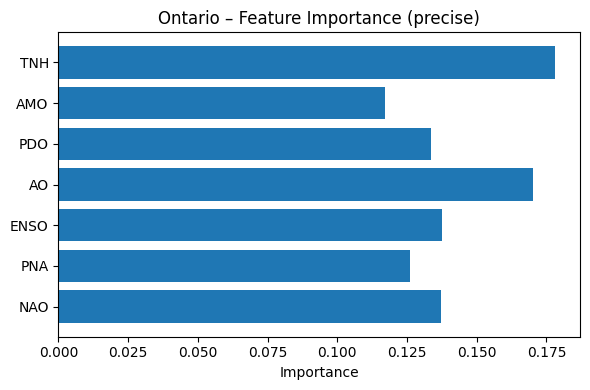


 Training Random Forest for Ontario — Mode: 5day
              precision    recall  f1-score   support

           0      0.969     1.000     0.984      1735
           1      0.000     0.000     0.000        56

    accuracy                          0.969      1791
   macro avg      0.484     0.500     0.492      1791
weighted avg      0.938     0.969     0.953      1791


 Classification Report for Ontario – 5day


precision  recall  f1-score   support
0                 0.969   1.000     0.984  1735.000
1                 0.000   0.000     0.000    56.000
accuracy          0.969   0.969     0.969     0.969
macro avg         0.484   0.500     0.492  1791.000
weighted avg      0.938   0.969     0.953  1791.000


 5-Fold Cross-Validation (F1 Score) for Ontario – 5day:
Mean F1: 0.042 ± 0.024


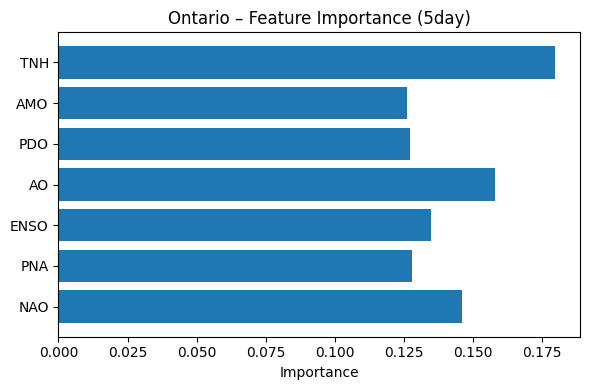


 Training Random Forest for Ontario — Mode: 10day
              precision    recall  f1-score   support

           0      0.939     1.000     0.968      1681
           1      0.000     0.000     0.000       110

    accuracy                          0.939      1791
   macro avg      0.469     0.500     0.484      1791
weighted avg      0.881     0.939     0.909      1791


 Classification Report for Ontario – 10day


precision  recall  f1-score   support
0                 0.939   1.000     0.968  1681.000
1                 0.000   0.000     0.000   110.000
accuracy          0.939   0.939     0.939     0.939
macro avg         0.469   0.500     0.484  1791.000
weighted avg      0.881   0.939     0.909  1791.000


 5-Fold Cross-Validation (F1 Score) for Ontario – 10day:
Mean F1: 0.078 ± 0.050


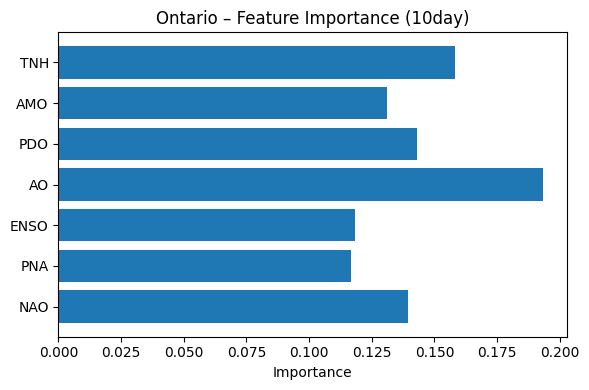


 Training Random Forest for Erie — Mode: precise
              precision    recall  f1-score   support

           0      0.993     1.000     0.997      1779
           1      0.000     0.000     0.000        12

    accuracy                          0.993      1791
   macro avg      0.497     0.500     0.498      1791
weighted avg      0.987     0.993     0.990      1791


 Classification Report for Erie – precise


precision  recall  f1-score   support
0                 0.993   1.000     0.997  1779.000
1                 0.000   0.000     0.000    12.000
accuracy          0.993   0.993     0.993     0.993
macro avg         0.497   0.500     0.498  1791.000
weighted avg      0.987   0.993     0.990  1791.000


 5-Fold Cross-Validation (F1 Score) for Erie – precise:
Mean F1: 0.000 ± 0.000


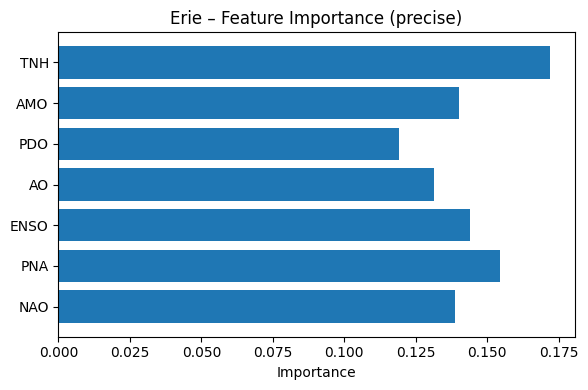


 Training Random Forest for Erie — Mode: 5day
              precision    recall  f1-score   support

           0      0.967     1.000     0.983      1732
           1      0.000     0.000     0.000        59

    accuracy                          0.967      1791
   macro avg      0.484     0.500     0.492      1791
weighted avg      0.935     0.967     0.951      1791


 Classification Report for Erie – 5day


precision  recall  f1-score   support
0                 0.967   1.000     0.983  1732.000
1                 0.000   0.000     0.000    59.000
accuracy          0.967   0.967     0.967     0.967
macro avg         0.484   0.500     0.492  1791.000
weighted avg      0.935   0.967     0.951  1791.000


 5-Fold Cross-Validation (F1 Score) for Erie – 5day:
Mean F1: 0.059 ± 0.041


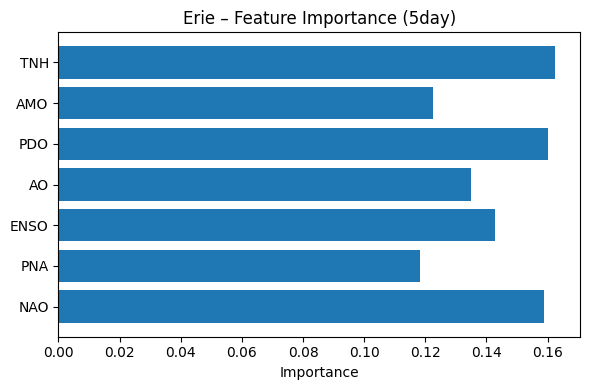


 Training Random Forest for Erie — Mode: 10day
              precision    recall  f1-score   support

           0      0.935     1.000     0.966      1674
           1      0.000     0.000     0.000       117

    accuracy                          0.935      1791
   macro avg      0.467     0.500     0.483      1791
weighted avg      0.874     0.935     0.903      1791


 Classification Report for Erie – 10day


precision  recall  f1-score   support
0                 0.935   1.000     0.966  1674.000
1                 0.000   0.000     0.000   117.000
accuracy          0.935   0.935     0.935     0.935
macro avg         0.467   0.500     0.483  1791.000
weighted avg      0.874   0.935     0.903  1791.000


 5-Fold Cross-Validation (F1 Score) for Erie – 10day:
Mean F1: 0.076 ± 0.053


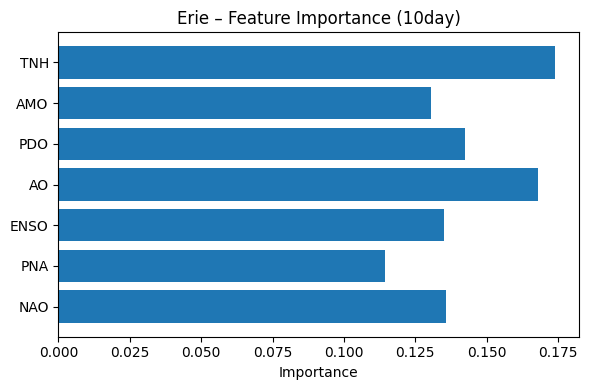


 Training Random Forest for Basin — Mode: precise
              precision    recall  f1-score   support

           0      0.993     1.000     0.997      1779
           1      0.000     0.000     0.000        12

    accuracy                          0.993      1791
   macro avg      0.497     0.500     0.498      1791
weighted avg      0.987     0.993     0.990      1791


 Classification Report for Basin – precise


precision  recall  f1-score   support
0                 0.993   1.000     0.997  1779.000
1                 0.000   0.000     0.000    12.000
accuracy          0.993   0.993     0.993     0.993
macro avg         0.497   0.500     0.498  1791.000
weighted avg      0.987   0.993     0.990  1791.000


 5-Fold Cross-Validation (F1 Score) for Basin – precise:
Mean F1: 0.000 ± 0.000


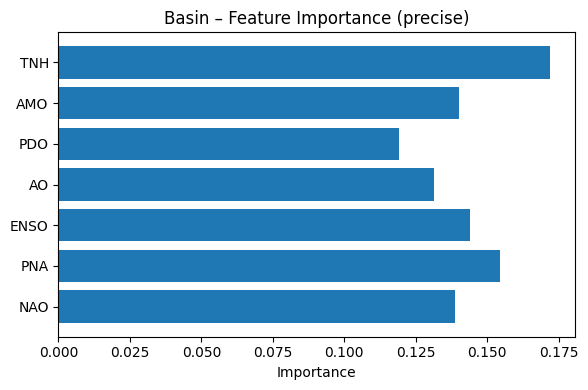


 Training Random Forest for Basin — Mode: 5day
              precision    recall  f1-score   support

           0      0.967     1.000     0.983      1732
           1      0.000     0.000     0.000        59

    accuracy                          0.967      1791
   macro avg      0.484     0.500     0.492      1791
weighted avg      0.935     0.967     0.951      1791


 Classification Report for Basin – 5day


precision  recall  f1-score   support
0                 0.967   1.000     0.983  1732.000
1                 0.000   0.000     0.000    59.000
accuracy          0.967   0.967     0.967     0.967
macro avg         0.484   0.500     0.492  1791.000
weighted avg      0.935   0.967     0.951  1791.000


 5-Fold Cross-Validation (F1 Score) for Basin – 5day:
Mean F1: 0.059 ± 0.041


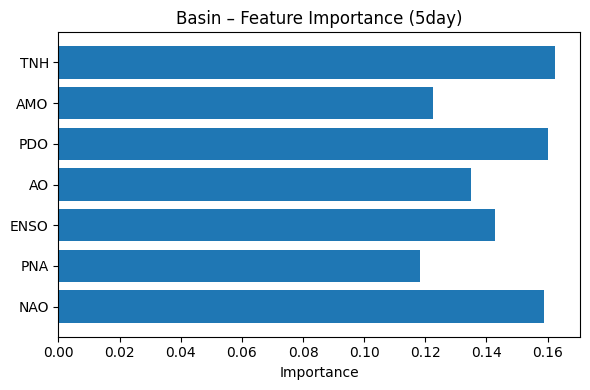


 Training Random Forest for Basin — Mode: 10day
              precision    recall  f1-score   support

           0      0.935     1.000     0.966      1674
           1      0.000     0.000     0.000       117

    accuracy                          0.935      1791
   macro avg      0.467     0.500     0.483      1791
weighted avg      0.874     0.935     0.903      1791


 Classification Report for Basin – 10day


precision  recall  f1-score   support
0                 0.935   1.000     0.966  1674.000
1                 0.000   0.000     0.000   117.000
accuracy          0.935   0.935     0.935     0.935
macro avg         0.467   0.500     0.483  1791.000
weighted avg      0.874   0.935     0.903  1791.000


 5-Fold Cross-Validation (F1 Score) for Basin – 10day:
Mean F1: 0.076 ± 0.053


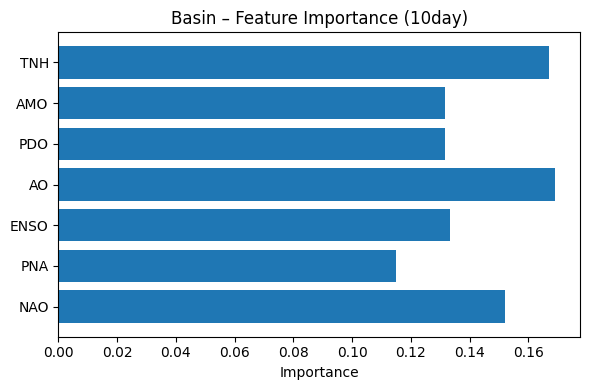

In [ ]:
# Random Forest Model - Ice Cover Onset Prediction (Precise, 5 Day window, 10 Day Window) - All Lakes

# Merge teleconnection data with ice cover data
df = pd.merge(ice_cover_df, df_tele.drop(columns=['Date']), on=['Year', 'Month'], how='left')

features = ['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH']

# Initialize result storage
lake_results_precise = {}
lake_results_5day = {}
lake_results_10day = {}

# Label onset windows function
def label_onsets(group, lake_col, mode='precise', window=0):
    group = group.sort_values('Date').reset_index(drop=True)
    group['onset'] = 0
    onset_index = group[group[lake_col] >= 5].head(1).index
    if not onset_index.empty:
        i = onset_index[0]
        if mode == 'precise':
            group.loc[i, 'onset'] = 1
        elif mode in ['5day', '10day']:
            group.loc[i:i+window-1, 'onset'] = 1
    return group

# Loop over lakes and window types
for lake in lakes:
    for mode, window in [('precise', 0), ('5day', 5), ('10day', 10)]:
        print(f"\n Training Random Forest for {lake} — Mode: {mode}")

        # Label onset
        df_lake = df.groupby('Year').apply(label_onsets, lake_col=lake, mode=mode, window=window).reset_index(drop=True)

        df_lake = df_lake.dropna(subset=features + ['onset'])
        X = df_lake[features]
        y = df_lake['onset']

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

        # Apply SMOTE if there is more than 1 class
        if len(np.unique(y_train)) > 1:
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        else:
            X_train_resampled, y_train_resampled = X_train, y_train

        # Train model
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        # Predict and report
        y_pred = rf.predict(X_test)
        print(classification_report(y_test, y_pred, digits=3))

        # Classification report as df
        report = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()

        # Save results to correct dictionary
        if mode == 'precise':
            lake_results_precise[lake] = {
                'model': rf,
                'classification_report': report,
                'feature_importances': dict(zip(features, rf.feature_importances_))
            }
        elif mode == '5day':
            lake_results_5day[lake] = {
                'model': rf,
                'classification_report': report,
                'feature_importances': dict(zip(features, rf.feature_importances_))
            }
        elif mode == '10day':
            lake_results_10day[lake] = {
                'model': rf,
                'classification_report': report,
                'feature_importances': dict(zip(features, rf.feature_importances_))
            }


        print(f"\n Classification Report for {lake} – {mode}")
        display(report_df.round(3))

        # Cross validation
        cv_scores = cross_val_score(rf, X, y, cv=5, scoring='f1')
        print(f"\n 5-Fold Cross-Validation (F1 Score) for {lake} – {mode}:")
        print(f"Mean F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

        # Feature importance
        importances = rf.feature_importances_
        plt.figure(figsize=(6, 4))
        plt.barh(indices, importances)
        plt.title(f'{lake} – Feature Importance ({mode})')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()





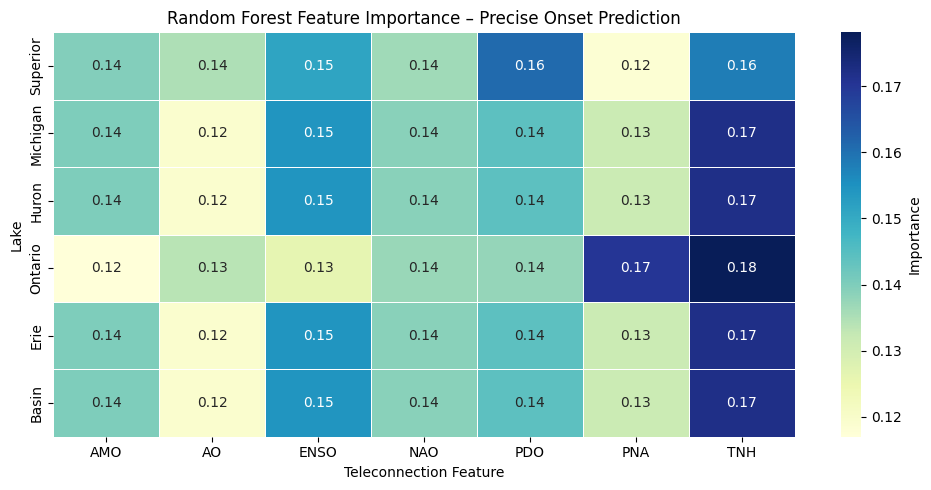

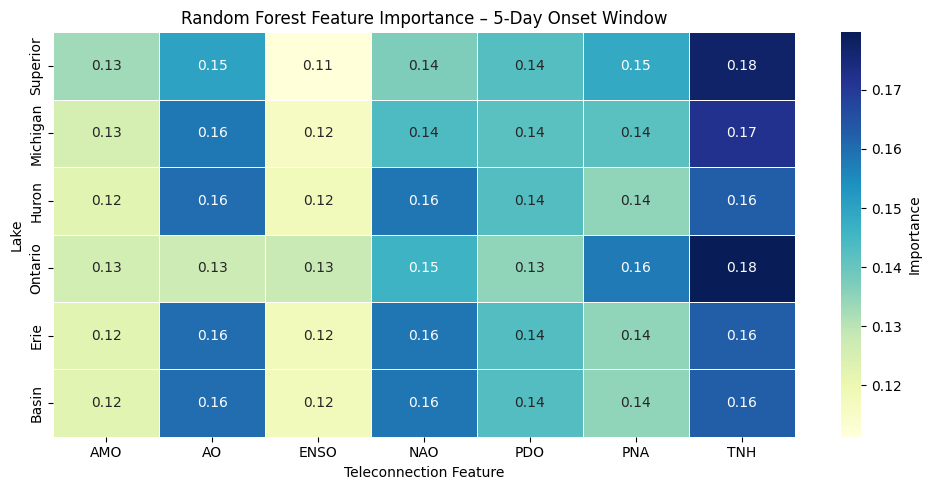

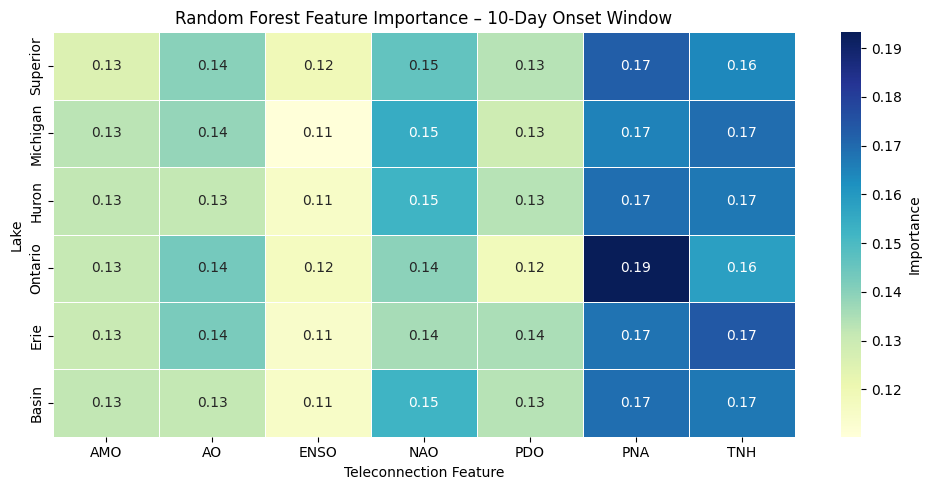

In [ ]:
# Random Forests Onset Prediction Feature Importance Heatmap

# Prepare storage for feature importance records
importance_records = []

# Loop through modes and their corresponding saved results
mode_dicts = {
    'precise': lake_results_precise,
    '5day': lake_results_5day,
    '10day': lake_results_10day
}

for mode, results_dict in mode_dicts.items():
    for lake in lakes:
        # Check if lake exists (sometimes skipped lakes won't exist)
        if lake not in results_dict:
            continue

        feature_importances = results_dict[lake]['feature_importances']

        # Store importance data for each feature
        for feature, importance in feature_importances.items():
            importance_records.append({
                'Lake': lake,
                'Mode': mode,
                'Feature': feature,
                'Importance': importance
            })

# Convert to DataFrame
imp_df = pd.DataFrame(importance_records)

# Plot heatmaps per mode
modes = ['precise', '5day', '10day']
mode_titles = {
    'precise': 'Random Forest Feature Importance – Precise Onset Prediction',
    '5day': 'Random Forest Feature Importance – 5-Day Onset Window',
    '10day': 'Random Forest Feature Importance – 10-Day Onset Window'
}

for mode in modes:
    pivot = (
        imp_df[imp_df['Mode'] == mode]
        .pivot(index='Lake', columns='Feature', values='Importance')
        .reindex(index=lakes)
    )

    plt.figure(figsize=(10, 5))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Importance'})
    plt.title(mode_titles[mode])
    plt.xlabel("Teleconnection Feature")
    plt.ylabel("Lake")
    plt.tight_layout()
    plt.show()





=== Superior ===
              precision    recall  f1-score   support

        Long       0.40      0.50      0.44         4
      Medium       0.40      0.33      0.36         6
       Short       0.00      0.00      0.00         2

    accuracy                           0.33        12
   macro avg       0.27      0.28      0.27        12
weighted avg       0.33      0.33      0.33        12



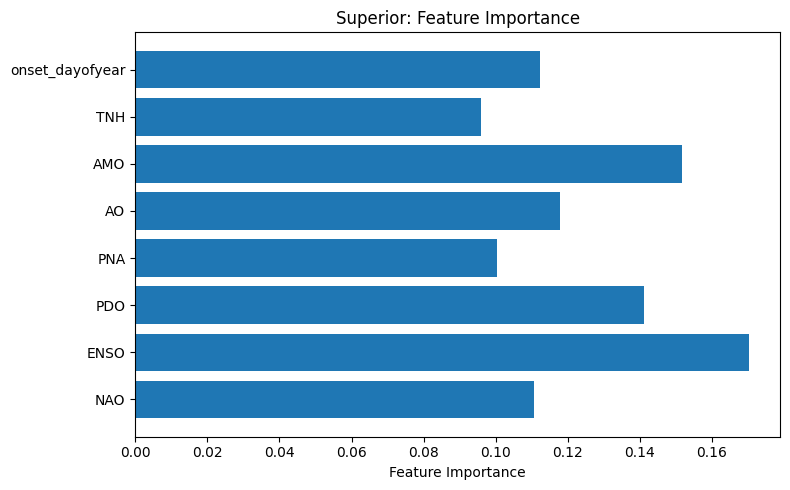

Skipping SMOTE for Michigan: Not enough samples in one or more classes

=== Michigan ===
              precision    recall  f1-score   support

        Long       0.00      0.00      0.00         1
      Medium       0.83      1.00      0.91        10
       Short       0.00      0.00      0.00         1

    accuracy                           0.83        12
   macro avg       0.28      0.33      0.30        12
weighted avg       0.69      0.83      0.76        12



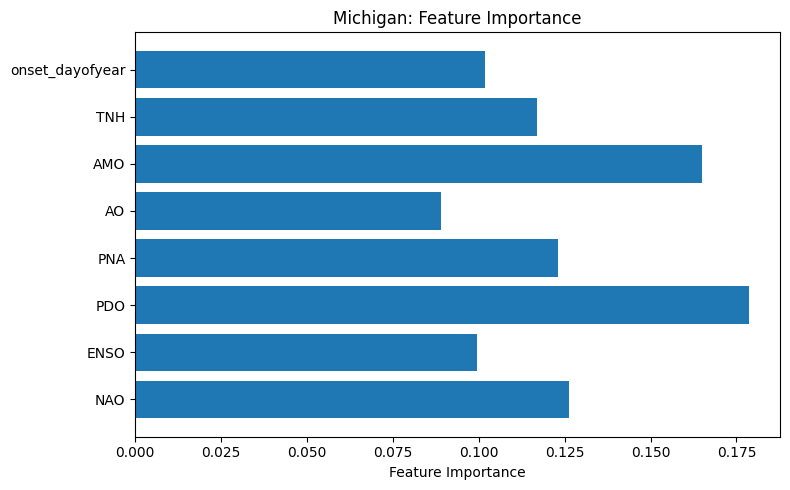


=== Huron ===
              precision    recall  f1-score   support

        Long       0.43      0.43      0.43         7
      Medium       0.20      0.20      0.20         5

    accuracy                           0.33        12
   macro avg       0.31      0.31      0.31        12
weighted avg       0.33      0.33      0.33        12



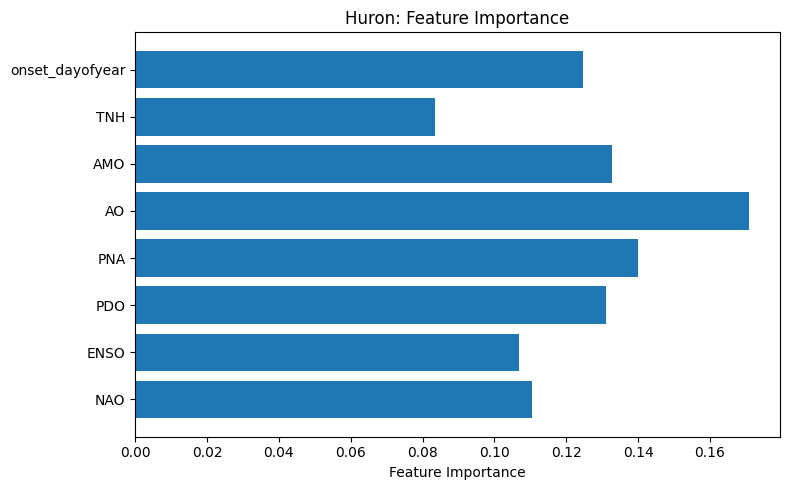

Skipping Ontario: Not enough samples in one or more classes to split.
Skipping SMOTE for Erie: Not enough samples in one or more classes

=== Erie ===
              precision    recall  f1-score   support

        Long       0.00      0.00      0.00         2
      Medium       0.58      1.00      0.74         7
       Short       0.00      0.00      0.00         3

    accuracy                           0.58        12
   macro avg       0.19      0.33      0.25        12
weighted avg       0.34      0.58      0.43        12



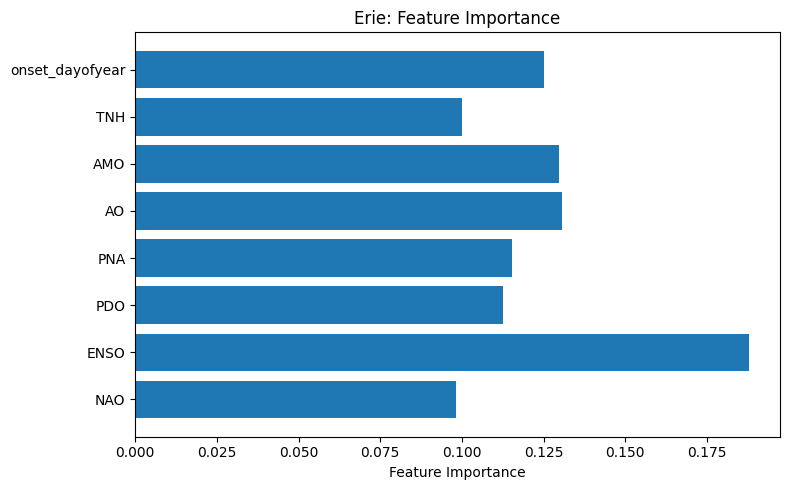

Skipping SMOTE for Basin: Not enough samples in one or more classes

=== Basin ===
              precision    recall  f1-score   support

        Long       0.00      0.00      0.00         3
      Medium       0.67      1.00      0.80         8
       Short       0.00      0.00      0.00         1

    accuracy                           0.67        12
   macro avg       0.22      0.33      0.27        12
weighted avg       0.44      0.67      0.53        12



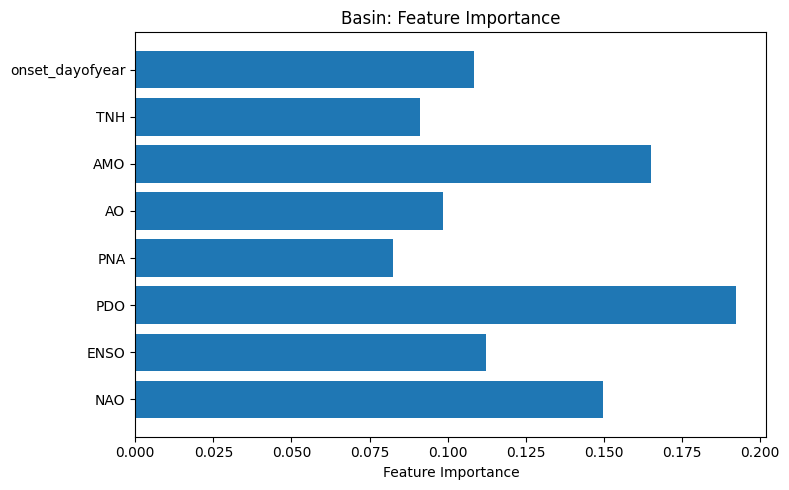

In [ ]:
# Random Forests Model - Duration Prediction (Short, Medium, Long Classes) - All Lakes

lake_results_duration = {}

# Define fixed duration classification function (quantile-based)
def classify_duration(days):
    if days <= 76:
        return 'Short'
    elif days <= 112:
        return 'Medium'
    else:
        return 'Long'

for lake in lakes:
    lake_df = long_df[long_df['Lake'] == lake].copy()

    # Fill NaN in IceCover
    lake_df['IceCover'] = lake_df['IceCover'].fillna(0)

    # Compute Season column if not already
    lake_df['Season'] = lake_df['Date'].apply(
        lambda d: f"{d.year}-{d.year + 1}" if d.month >= 10 else f"{d.year - 1}-{d.year}"
    )

    # Compute Duration function
    def compute_duration(group):
        threshold_days = group[group['IceCover'] >= 5]
        if threshold_days.empty:
            return pd.Series({'ice_duration_days': 0})
        start = threshold_days['Date'].min()
        end = threshold_days['Date'].max()
        duration = (end - start).days + 1
        return pd.Series({'ice_duration_days': duration})

    # Compute Onset function
    def get_onset_day(group):
        onset = group[group['IceCover'] >= 5]['Date'].min()
        if pd.isna(onset):
            return pd.Series({'onset_dayofyear': np.nan})
        return pd.Series({'onset_dayofyear': onset.dayofyear})

    # Calculate durations and onset
    ice_durations = lake_df.groupby('Season').apply(compute_duration).reset_index()
    onsets = lake_df.groupby('Season').apply(get_onset_day).reset_index()

    # Add Year column for merging
    ice_durations['Year'] = ice_durations['Season'].str[:4].astype(int)

    # Merge together
    model_df = (
        ice_durations
        .merge(onsets, on='Season')
        .merge(winter_avg, on='Year')
        .dropna()
    )

    if len(model_df) < 10:
        print(f"Skipping {lake}: Not enough data")
        continue

    # Classify duration using fixed quantile thresholds
    model_df['duration_class'] = model_df['ice_duration_days'].apply(classify_duration)

    features = ['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH', 'onset_dayofyear']
    X = model_df[features]
    y = model_df['duration_class']

    # Check that all classes have at least 2 samples
    if y.value_counts().min() < 2:
        print(f"Skipping {lake}: Not enough samples in one or more classes to split.")
        continue

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
      X, y, stratify=y, test_size=0.3, random_state=42)

    # Apply SMOTE if enough samples
    if len(np.unique(y_train)) < 2:
        print(f"Skipping {lake}: Not enough class diversity to train model")
        continue

    if y_train.value_counts().min() > 5:
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    else:
        print(f"Skipping SMOTE for {lake}: Not enough samples in one or more classes")
        X_train_resampled, y_train_resampled = X_train, y_train

    # Train Random Forest
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)

    # Report
    print(f"\n=== {lake} ===")
    print(classification_report(y_test, y_pred))

    # Feature importance
    importances = clf.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.barh(features, importances)
    plt.xlabel("Feature Importance")
    plt.title(f"{lake}: Feature Importance")
    plt.tight_layout()
    plt.show()

    # Save results
    lake_results_duration[lake] = {
        'model': clf,
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'feature_importances': dict(zip(features, importances))
    }


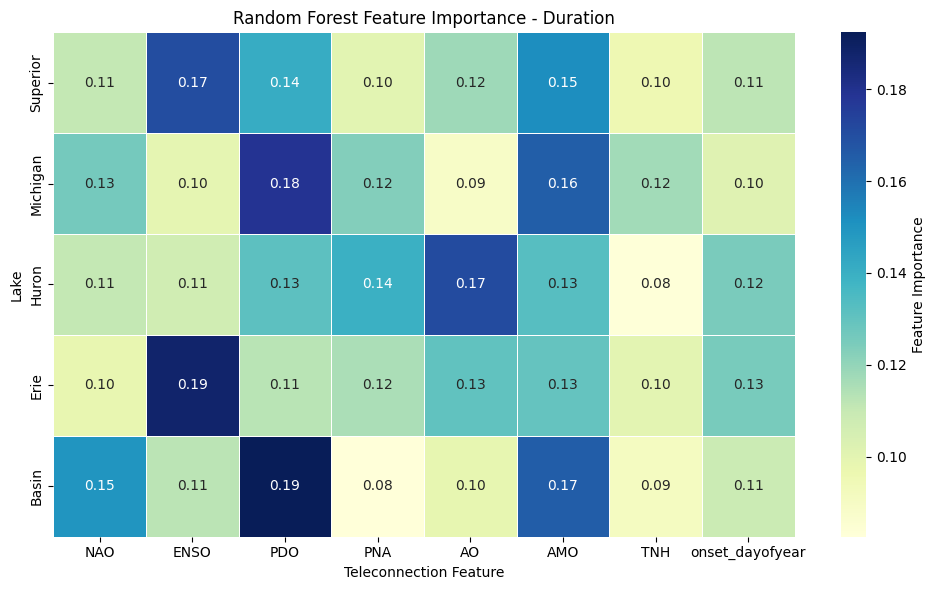

In [ ]:
# Random Forests Duration Model Feature Importance Heatmap

importance_df = pd.DataFrame({
    lake: data['feature_importances']
    for lake, data in lake_results_duration.items()
}).T

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    importance_df,
    annot=True,
    cmap='YlGnBu',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Feature Importance'}
)
plt.title("Random Forest Feature Importance - Duration")
plt.xlabel("Teleconnection Feature")
plt.ylabel("Lake")
plt.tight_layout()
plt.show()


### Long Short-Term Memory (LSTM) Model

In [ ]:
# Long Short Term Memory (LSTM) Model - Onset Prediction (Precise, 5 day window, 10 day window) - All Lakes

# Initialize results storage
lake_results_lstm_precise = {}
lake_results_lstm_5day = {}
lake_results_lstm_10day = {}

df_tele_monthly = df_tele.drop(columns='Date')

# Onset Prediction for Each Lake and Window
def label_exact_onset(group):
    group = group.sort_values('Date').reset_index(drop=True)
    group['onset_exact'] = 0
    group['onset_5day'] = 0
    group['onset_10day'] = 0
    onset_candidates = group[group['IceCover'] >= 5]
    if not onset_candidates.empty:
        onset_day = onset_candidates['Date'].min()
        group['delta'] = (group['Date'] - onset_day).dt.days
        group.loc[group['delta'] == 0, 'onset_exact'] = 1
        group.loc[group['delta'].between(0, 4), 'onset_5day'] = 1
        group.loc[group['delta'].between(0, 9), 'onset_10day'] = 1
        group = group.drop(columns='delta')
    return group

# Model function
def build_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

seq_len = 30

# Loop through lakes
for lake in lakes:
    lake_df = long_df[long_df['Lake'] == lake].copy()
    df = pd.merge(lake_df, df_tele_monthly, on=['Year', 'Month'], how='left')
    df = df.groupby('Year').apply(label_exact_onset).reset_index(drop=True)

    features = ['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH']
    df = df.dropna(subset=features + ['onset_exact'])

    for label, label_name in zip(['onset_exact', 'onset_5day', 'onset_10day'],
                                 ['Exact Onset', '5-Day Window', '10-Day Window']):

        sequences = []
        labels = []

        for i in range(len(df) - seq_len):
            X_seq = df[features].iloc[i:i + seq_len].values
            y = df[label].iloc[i + seq_len]
            sequences.append(X_seq)
            labels.append(y)

        if len(labels) == 0 or pd.Series(labels).value_counts().min() < 5:
            print(f"Skipping {lake} - {label_name}: Insufficient sequence data")
            continue

        X = np.array(sequences)
        y = np.array(labels)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, stratify=y, test_size=0.3, random_state=42)

        weights = class_weight.compute_class_weight(
            class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weights = dict(enumerate(weights))

        # Build model
        lstm_model = build_lstm_model((seq_len, len(features)))

        lstm_model.fit(
            X_train, y_train,
            epochs=15, batch_size=32,
            validation_split=0.2,
            class_weight=class_weights,
            verbose=1
        )

        y_pred = lstm_model.predict(X_test) > 0.5

        # Report
        print(f"\n=== {lake} - LSTM {label_name} Prediction ===")
        print(classification_report(y_test, y_pred))

        report = classification_report(y_test, y_pred, output_dict=True)

        # Store results
        if label_name == 'Exact Onset':
            lake_results_lstm_precise[lake] = {
                'model': lstm_model,
                'classification_report': report,
                'feature_importances': "N/A"
            }
        elif label_name == '5-Day Window':
            lake_results_lstm_5day[lake] = {
                'model': lstm_model,
                'classification_report': report,
                'feature_importances': "N/A"
            }
        elif label_name == '10-Day Window':
            lake_results_lstm_10day[lake] = {
                'model': lstm_model,
                'classification_report': report,
                'feature_importances': "N/A"
            }



Epoch 1/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7249 - loss: 0.7704 - val_accuracy: 0.5535 - val_loss: 0.6875
Epoch 2/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7096 - loss: 0.5168 - val_accuracy: 0.5403 - val_loss: 0.7327
Epoch 3/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5103 - loss: 0.7012 - val_accuracy: 0.7052 - val_loss: 0.4397
Epoch 4/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7337 - loss: 0.6064 - val_accuracy: 0.4862 - val_loss: 0.6959
Epoch 5/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5713 - loss: 0.5741 - val_accuracy: 0.5295 - val_loss: 0.6882
Epoch 6/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5445 - loss: 0.5306 - val_accuracy: 0.6258 - val_loss: 0.5493
Epoch 7/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6562 - loss: 0.5332 - val_accuracy: 0.6101 - val_loss: 0.6029
Epoch 8/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6734 - loss: 0.4857 - val_accu

In [ ]:
# Long Short Term Memory (LSTM) Model - Duration Prediction (Short, Medium, Long Classes) - All Lakes

lake_results_lstm_duration = {}

# Assign winter seasons
def assign_ice_season(month, year):
    if month >= 10:
        return year + 1
    elif month <= 4:
        return year
    else:
        return np.nan

ice_cover_df['SeasonYear'] = ice_cover_df.apply(lambda row: assign_ice_season(row['Month'], row['Year']), axis=1)
df_tele['SeasonYear'] = df_tele.apply(lambda row: assign_ice_season(row['Month'], row['Year']), axis=1)

# Filter for winter months
ice_cover_df = ice_cover_df[ice_cover_df['Month'].isin([10, 11, 12, 1, 2, 3, 4])]
df_tele = df_tele[df_tele['Month'].isin([10, 11, 12, 1, 2, 3, 4])]

# Compute winter averages
winter_avg = df_tele.groupby('SeasonYear')[features].mean().reset_index().rename(columns={'SeasonYear': 'Year'})

features_onset = features + ['onset_dayofyear']
seq_len = 1

# Loop through lakes
for lake in lakes:
    print(f"\nTraining LSTM for {lake} Duration Prediction")

    lake_df = ice_cover_df[['Date', 'Year', 'Month', 'SeasonYear', lake]].copy()
    lake_df = lake_df.rename(columns={lake: 'IceCover'})

    def compute_duration(group):
        threshold_days = group[group['IceCover'] >= 5]
        if threshold_days.empty:
            return pd.Series({'ice_duration_days': 0})
        start = threshold_days['Date'].min()
        end = threshold_days['Date'].max()
        duration = (end - start).days + 1
        return pd.Series({'ice_duration_days': duration})

    def get_onset_day(group):
        onset = group[group['IceCover'] >= 5]['Date'].min()
        if pd.isna(onset):
            return pd.Series({'onset_dayofyear': np.nan})
        return pd.Series({'onset_dayofyear': onset.dayofyear})

    durations = lake_df.groupby('Year').apply(compute_duration).reset_index()
    onsets = lake_df.groupby('Year').apply(get_onset_day).reset_index()

    model_df = (
        durations
        .merge(onsets, on='Year')
        .merge(winter_avg, on='Year')
        .dropna()
    )

    if len(model_df) < seq_len + 1:
        print(f"Skipping {lake}: Not enough data")
        continue

    model_df['duration_class'] = model_df['ice_duration_days'].apply(classify_duration)
    le = LabelEncoder()
    y_label = le.fit_transform(model_df['duration_class'])

    X = model_df[features_onset].values.reshape(-1, seq_len, len(features_onset))
    y_cat = to_categorical(y_label)

    # Check class counts
    if np.min(np.bincount(y_label)) < 2:
        print(f"Skipping {lake}: Not enough samples in one or more classes to split.")
        continue

    # Train/test split → stratify using integer y
    X_train, X_test, y_train_labels, y_test_labels = train_test_split(
        X, y_label, stratify=y_label, test_size=0.3, random_state=42
    )

    y_train = to_categorical(y_train_labels)
    y_test = to_categorical(y_test_labels)

    weights = class_weight.compute_class_weight(
        class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels
    )
    class_weights = dict(enumerate(weights))

    lstm_d_model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(seq_len, len(features_onset))),
        Dense(32, activation='relu'),
        Dense(y_cat.shape[1], activation='softmax')
    ])

    lstm_d_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    lstm_d_model.fit(
        X_train, y_train,
        epochs=15, batch_size=8,
        validation_split=0.2,
        class_weight=class_weights,
        verbose=1
    )

    y_pred_prob = lstm_d_model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    print("\nLSTM Classification Report for Duration Class:")
    print(classification_report(y_test_labels, y_pred, target_names=le.classes_))

    # Save results
    lake_results_lstm_duration[lake] = {
        'model': lstm_d_model,
        'classification_report': classification_report(y_test_labels, y_pred, output_dict=True),
        'feature_importances': "N/A"
    }



Training LSTM for Superior Duration Prediction
Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step - accuracy: 0.2997 - loss: 1.0867 - val_accuracy: 0.0000e+00 - val_loss: 1.0692
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4702 - loss: 1.0577 - val_accuracy: 0.0000e+00 - val_loss: 1.0496
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4915 - loss: 0.9694 - val_accuracy: 0.1667 - val_loss: 1.0294
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6151 - loss: 0.9559 - val_accuracy: 0.3333 - val_loss: 1.0138
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6776 - loss: 0.9487 - val_accuracy: 0.3333 - val_loss: 1.0036
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5994 - loss: 0.9209 - val_accuracy: 0.3333 - val_loss: 0.9922
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7159 - loss: 0.8651 - val_accuracy: 0.3333 - val_loss: 0.9782
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7543 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step

LSTM Classification Report for Duration Class:
              precision    recall  f1-score   support

        Long       0.50      1.00      0.67         1
      Medium       0.00      0.00      0.00         3
       Short       0.78      0.88      0.82         8

    accuracy                           0.67        12
   macro avg       0.43      0.62      0.50        12
weighted avg       0.56      0.67      0.60        12


Training LSTM for Erie Duration Prediction
Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.4006 - loss: 1.0965 - val_accuracy: 0.1667 - val_loss: 1.0751
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4077 - loss: 1.0581 - val_accuracy: 0.1667 - val_loss: 1.0697
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3608 - loss: 1.0922 - val_accuracy: 0.3333 - val_loss: 1.0647
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3381 - loss: 1.0410 - val_accuracy: 0.3333 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step

LSTM Classification Report for Duration Class:
              precision    recall  f1-score   support

        Long       0.86      1.00      0.92         6
      Medium       1.00      0.33      0.50         3
       Short       0.75      1.00      0.86         3

    accuracy                           0.83        12
   macro avg       0.87      0.78      0.76        12
weighted avg       0.87      0.83      0.80        12


Training LSTM for Basin Duration Prediction
Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.1463 - loss: 1.1342 - val_accuracy: 0.1667 - val_loss: 1.1004
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1534 - loss: 0.9853 - val_accuracy: 0.1667 - val_loss: 1.0914
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2386 - loss: 1.0621 - val_accuracy: 0.3333 - val_loss: 1.0812
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3082 - loss: 1.0315 - val_accuracy: 0.5000 - val

### XGBoost Model


=== Superior - XGBoost Exact Onset Prediction ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1779
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1791
   macro avg       0.50      0.50      0.50      1791
weighted avg       0.99      0.99      0.99      1791



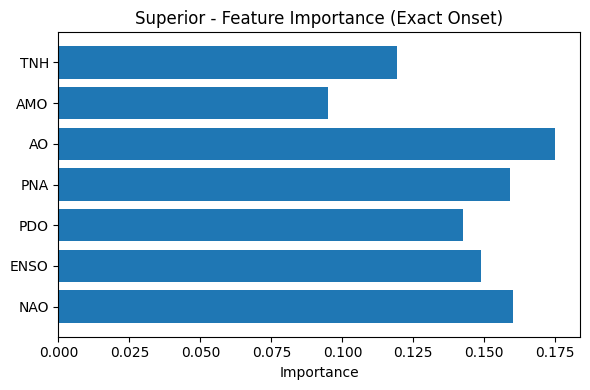


=== Superior - XGBoost 5-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1714
           1       0.59      0.21      0.31        77

    accuracy                           0.96      1791
   macro avg       0.78      0.60      0.64      1791
weighted avg       0.95      0.96      0.95      1791



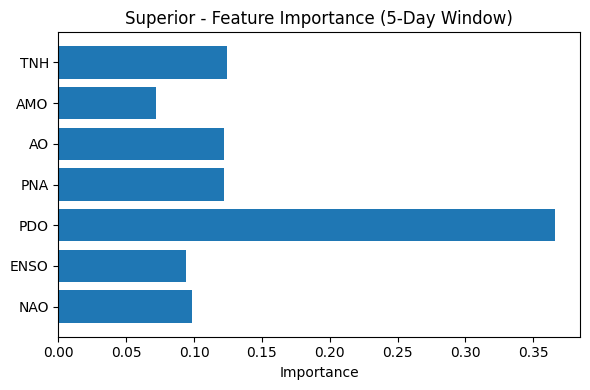


=== Superior - XGBoost 10-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1636
           1       0.75      0.28      0.41       155

    accuracy                           0.93      1791
   macro avg       0.84      0.64      0.69      1791
weighted avg       0.92      0.93      0.91      1791



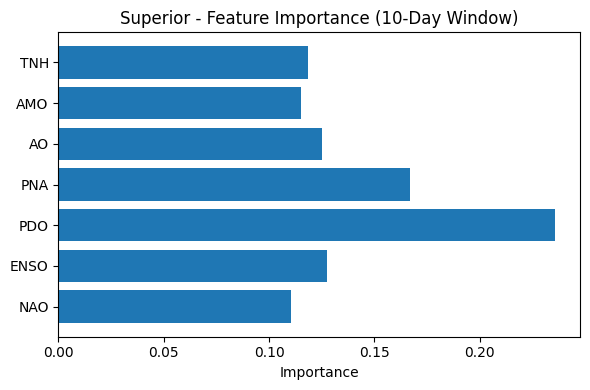


=== Michigan - XGBoost Exact Onset Prediction ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1779
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1791
   macro avg       0.50      0.50      0.50      1791
weighted avg       0.99      0.99      0.99      1791



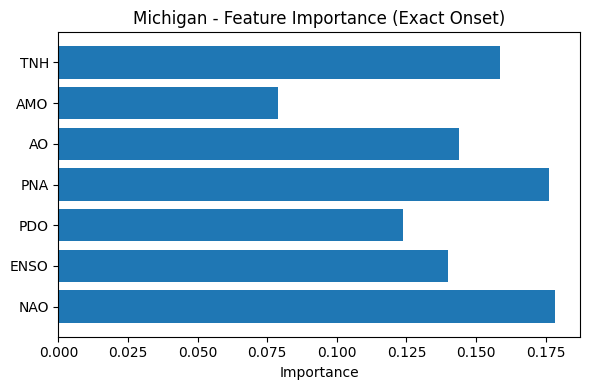


=== Michigan - XGBoost 5-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1714
           1       0.59      0.21      0.31        77

    accuracy                           0.96      1791
   macro avg       0.78      0.60      0.64      1791
weighted avg       0.95      0.96      0.95      1791



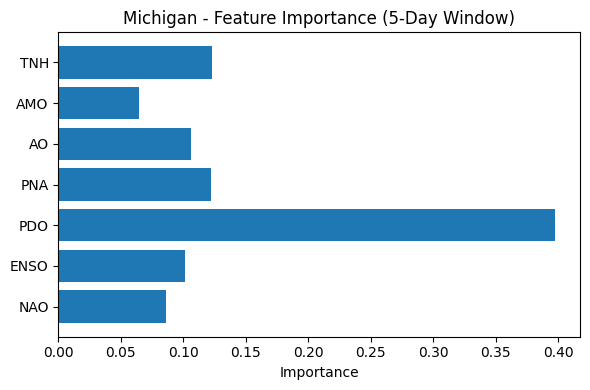


=== Michigan - XGBoost 10-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1636
           1       0.81      0.28      0.41       155

    accuracy                           0.93      1791
   macro avg       0.87      0.64      0.69      1791
weighted avg       0.92      0.93      0.92      1791



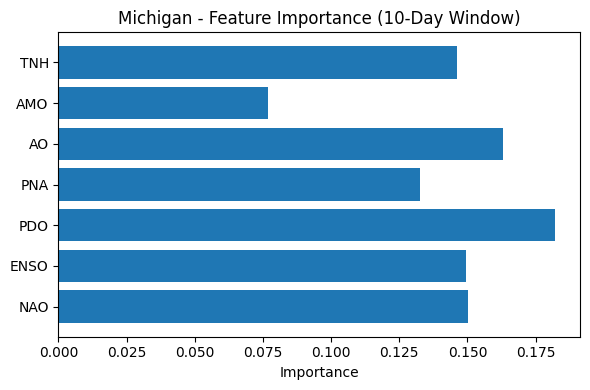


=== Huron - XGBoost Exact Onset Prediction ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1779
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1791
   macro avg       0.50      0.50      0.50      1791
weighted avg       0.99      0.99      0.99      1791



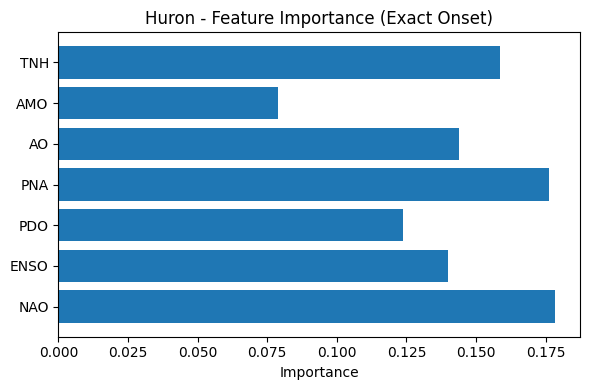


=== Huron - XGBoost 5-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1732
           1       0.00      0.00      0.00        59

    accuracy                           0.97      1791
   macro avg       0.48      0.50      0.49      1791
weighted avg       0.94      0.97      0.95      1791



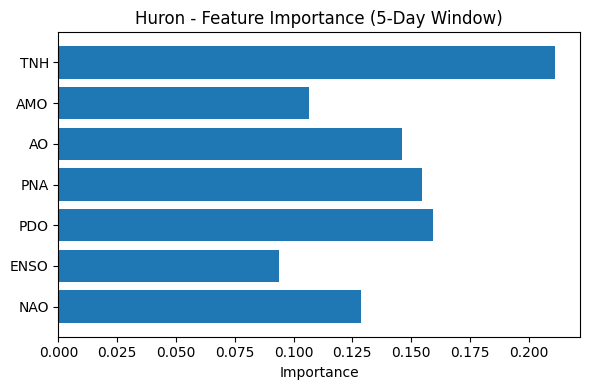


=== Huron - XGBoost 10-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1674
           1       0.00      0.00      0.00       117

    accuracy                           0.93      1791
   macro avg       0.47      0.50      0.48      1791
weighted avg       0.87      0.93      0.90      1791



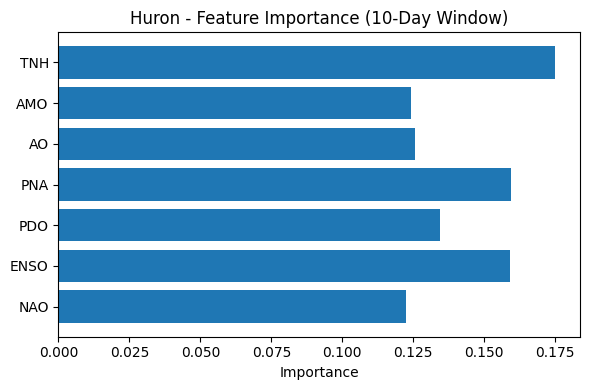


=== Ontario - XGBoost Exact Onset Prediction ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1761
           1       0.75      0.60      0.67        30

    accuracy                           0.99      1791
   macro avg       0.87      0.80      0.83      1791
weighted avg       0.99      0.99      0.99      1791



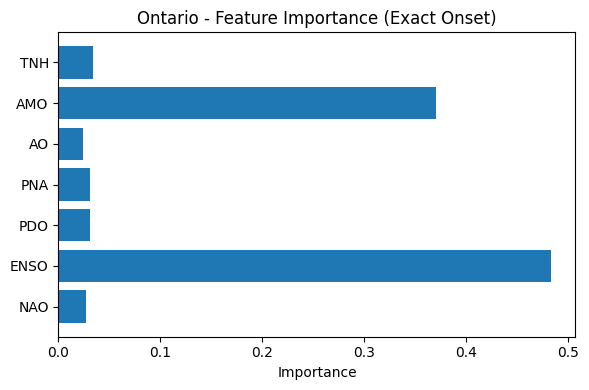


=== Ontario - XGBoost 5-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1660
           1       0.72      0.62      0.67       131

    accuracy                           0.95      1791
   macro avg       0.85      0.80      0.82      1791
weighted avg       0.95      0.95      0.95      1791



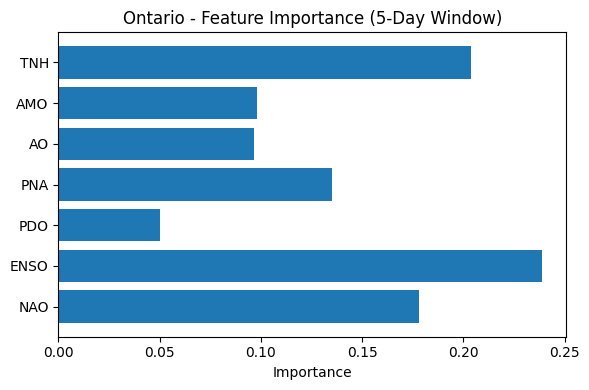


=== Ontario - XGBoost 10-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1530
           1       0.76      0.66      0.70       261

    accuracy                           0.92      1791
   macro avg       0.85      0.81      0.83      1791
weighted avg       0.92      0.92      0.92      1791



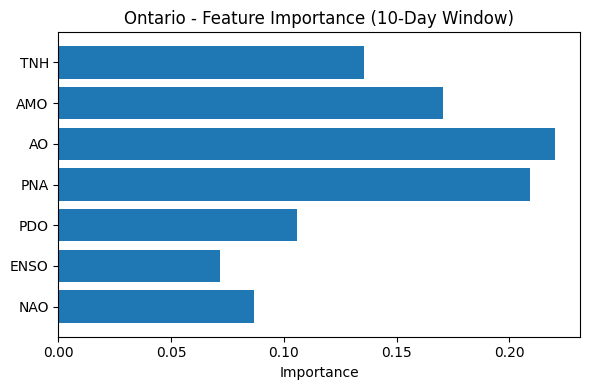


=== Erie - XGBoost Exact Onset Prediction ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1779
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1791
   macro avg       0.50      0.50      0.50      1791
weighted avg       0.99      0.99      0.99      1791



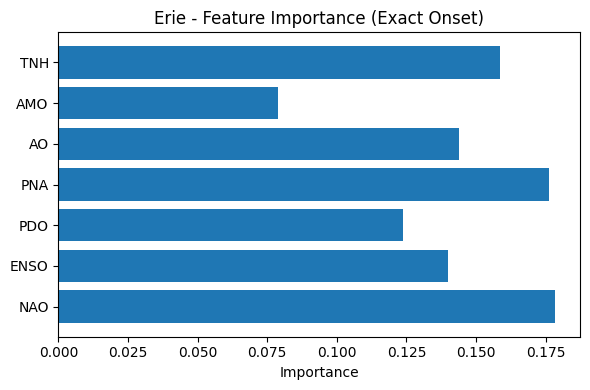


=== Erie - XGBoost 5-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1732
           1       0.00      0.00      0.00        59

    accuracy                           0.97      1791
   macro avg       0.48      0.50      0.49      1791
weighted avg       0.94      0.97      0.95      1791



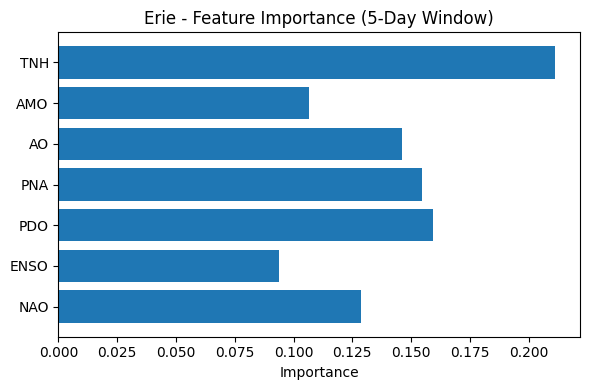


=== Erie - XGBoost 10-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1636
           1       0.71      0.23      0.35       155

    accuracy                           0.93      1791
   macro avg       0.82      0.61      0.65      1791
weighted avg       0.91      0.93      0.91      1791



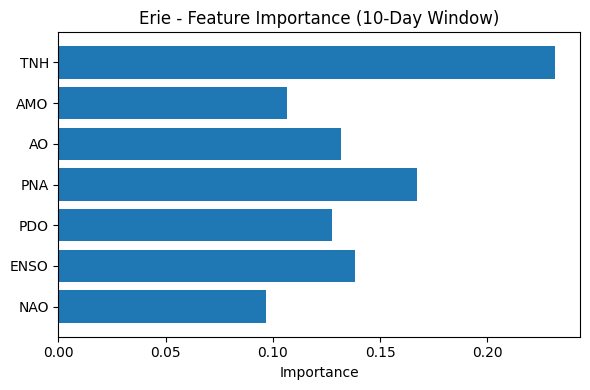


=== Basin - XGBoost Exact Onset Prediction ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1779
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1791
   macro avg       0.50      0.50      0.50      1791
weighted avg       0.99      0.99      0.99      1791



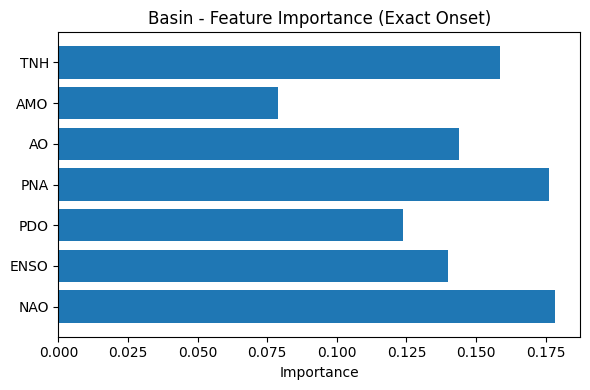


=== Basin - XGBoost 5-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1732
           1       0.00      0.00      0.00        59

    accuracy                           0.97      1791
   macro avg       0.48      0.50      0.49      1791
weighted avg       0.94      0.97      0.95      1791



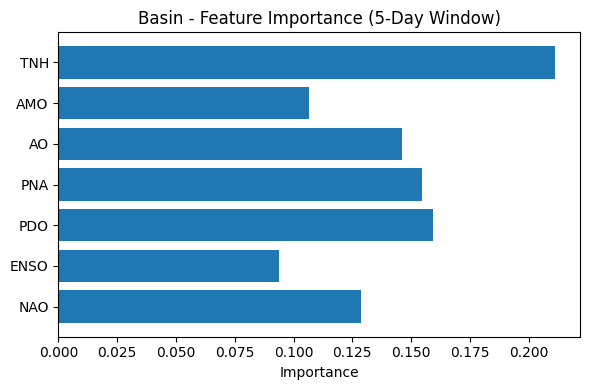


=== Basin - XGBoost 10-Day Window Prediction ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1674
           1       0.00      0.00      0.00       117

    accuracy                           0.93      1791
   macro avg       0.47      0.50      0.48      1791
weighted avg       0.87      0.93      0.90      1791



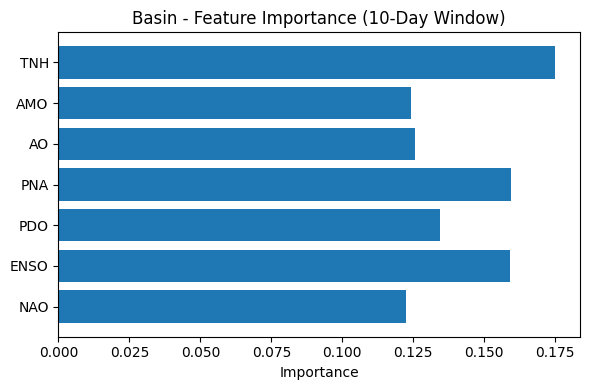

In [ ]:
# XGBoost Model - Onset Prediction (Precise, 5 day window, 10 day window) - All lakes

lake_results_xgb_precise = {}
lake_results_xgb_5day = {}
lake_results_xgb_10day = {}

df_tele_monthly = df_tele.drop(columns='Date')

# Onset Day Classification for Each Lake
def label_exact_onset(group):
    group = group.sort_values('Date').reset_index(drop=True)
    group['onset_exact'] = 0
    group['onset_5day'] = 0
    group['onset_10day'] = 0
    onset_candidates = group[group['IceCover'] >= 5]
    if not onset_candidates.empty:
        onset_day = onset_candidates['Date'].min()
        group['delta'] = (group['Date'] - onset_day).dt.days
        group.loc[group['delta'] == 0, 'onset_exact'] = 1
        group.loc[group['delta'].between(0, 4), 'onset_5day'] = 1
        group.loc[group['delta'].between(0, 9), 'onset_10day'] = 1
        group = group.drop(columns='delta')
    return group

importance_collectors = {
    'Exact Onset': {},
    '5-Day Window': {},
    '10-Day Window': {}}

for lake in lakes:
    lake_df = long_df[long_df['Lake'] == lake].copy()
    df = pd.merge(lake_df, df_tele_monthly, on=['Year', 'Month'], how='left')
    df = df.groupby('Year').apply(label_exact_onset).reset_index(drop=True)

    features = ['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH']
    df = df.dropna(subset=features + ['onset_exact'])

    for label, label_name in zip(['onset_exact', 'onset_5day', 'onset_10day'],
                                 ['Exact Onset', '5-Day Window', '10-Day Window']):

        X = df[features]
        y = df[label]

        if y.value_counts().min() < 5:
            print(f"Skipping {lake} - {label_name}: Insufficient positive/negative samples")
            continue

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, stratify=y, test_size=0.3, random_state=42)

               # apply SMOTE
        if len(np.unique(y_train)) > 1:
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        else:
            X_train_resampled, y_train_resampled = X_train, y_train

        # Train model (NO scale_pos_weight)
        model_xgb = xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

        model_xgb.fit(X_train, y_train)
        y_pred = model_xgb.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True)

        # Store results
        if label_name == 'Exact Onset':
            lake_results_xgb_precise[lake] = {
                'model': model_xgb,
                'classification_report': report,
                'feature_importances': dict(zip(features, model_xgb.feature_importances_))
            }
        elif label_name == '5-Day Window':
            lake_results_xgb_5day[lake] = {
                'model': model_xgb,
                'classification_report': report,
                'feature_importances': dict(zip(features, model_xgb.feature_importances_))
            }
        elif label_name == '10-Day Window':
            lake_results_xgb_10day[lake] = {
                'model': model_xgb,
                'classification_report': report,
                'feature_importances': dict(zip(features, model_xgb.feature_importances_))
            }

        # Report
        print(f"\n=== {lake} - XGBoost {label_name} Prediction ===")
        print(classification_report(y_test, y_pred))

        # Feature Importance Plot
        importances = model_xgb.feature_importances_
        indices = np.arange(len(features))

        plt.figure(figsize=(6, 4))
        plt.barh(indices, importances)
        plt.yticks(indices, features)
        plt.xlabel("Importance")
        plt.title(f"{lake} - Feature Importance ({label_name})")
        plt.tight_layout()
        plt.show()

        # # Confusion Matrix
        # ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test)
        # plt.title(f"Confusion Matrix - {lake} {label_name} (XGBoost)")
        # plt.tight_layout()
        # plt.show()

        importance_collectors[label_name][lake] = dict(zip(features, model_xgb.feature_importances_))



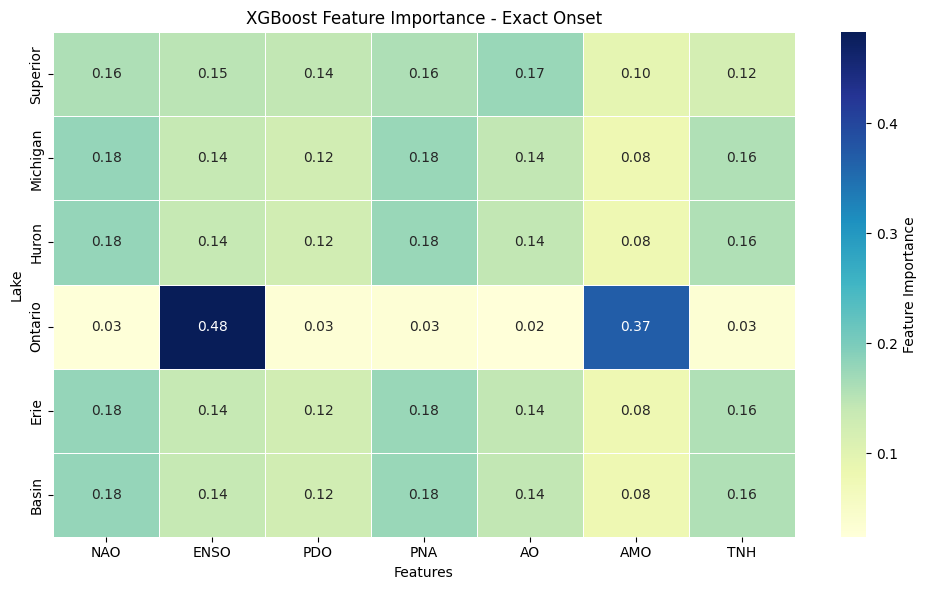

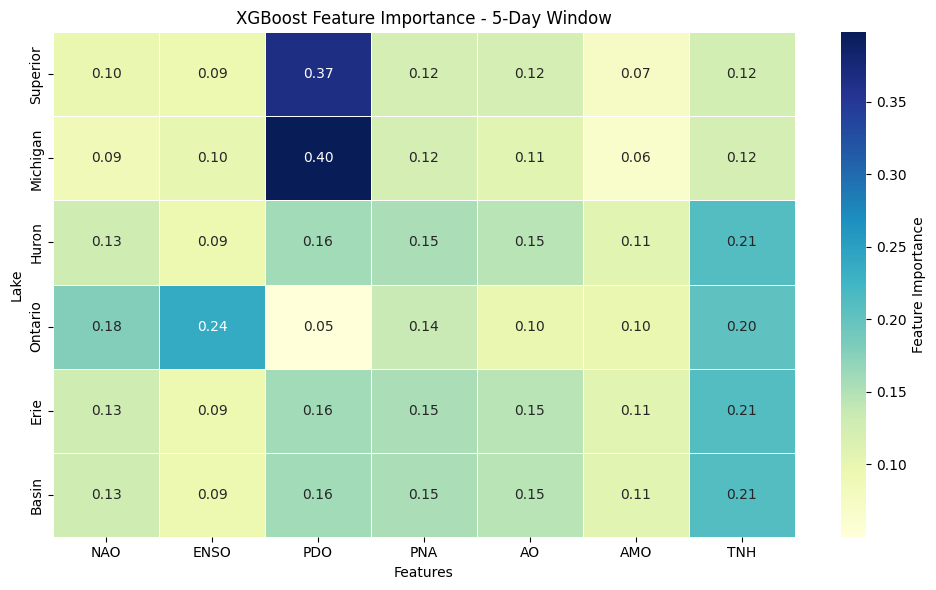

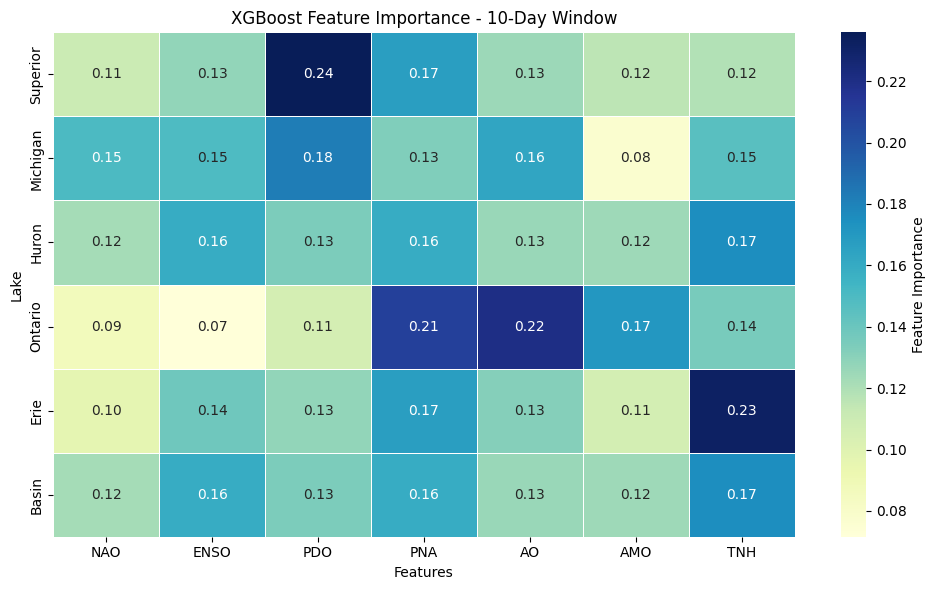

In [ ]:
# XGBoost Model Onset Prediction Heatmap of Feature Importance

# Plot
for label_name in ['Exact Onset', '5-Day Window', '10-Day Window']:
    importance_df = pd.DataFrame(importance_collectors[label_name]).T
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        importance_df,
        annot=True,
        cmap='YlGnBu',
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={'label': 'Feature Importance'}
    )
    plt.title(f"XGBoost Feature Importance - {label_name}")
    plt.xlabel("Features")
    plt.ylabel("Lake")
    plt.tight_layout()
    plt.show()



=== Superior - XGBoost Duration Class Prediction ===
              precision    recall  f1-score   support

        Long       0.80      0.67      0.73         6
      Medium       0.00      0.00      0.00         3
       Short       0.40      0.67      0.50         3

    accuracy                           0.50        12
   macro avg       0.40      0.44      0.41        12
weighted avg       0.50      0.50      0.49        12



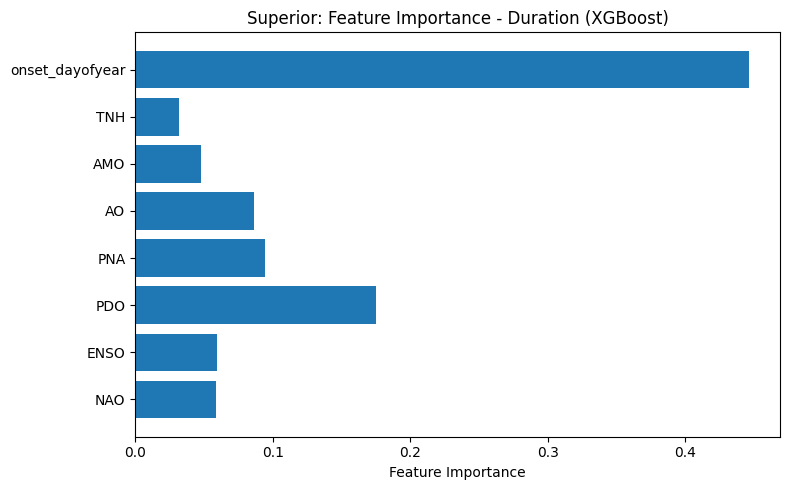


=== Michigan - XGBoost Duration Class Prediction ===
              precision    recall  f1-score   support

        Long       0.71      0.83      0.77         6
      Medium       0.50      0.25      0.33         4
       Short       0.33      0.50      0.40         2

    accuracy                           0.58        12
   macro avg       0.52      0.53      0.50        12
weighted avg       0.58      0.58      0.56        12



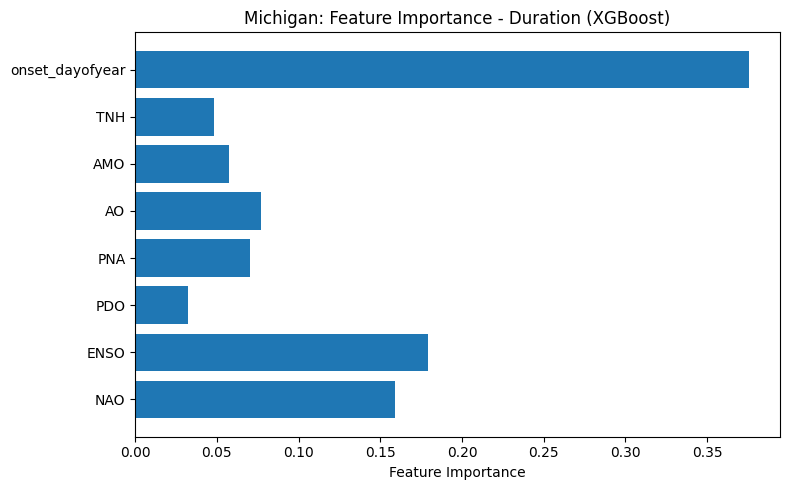

Skipping Huron: Not enough samples in one or more classes to split.

=== Ontario - XGBoost Duration Class Prediction ===
              precision    recall  f1-score   support

        Long       1.00      1.00      1.00         1
      Medium       0.50      0.67      0.57         3
       Short       0.86      0.75      0.80         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.79        12
weighted avg       0.78      0.75      0.76        12



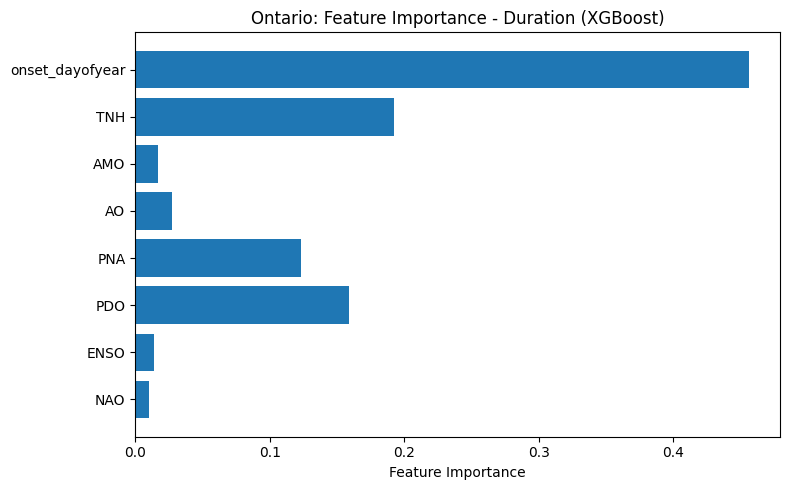


=== Erie - XGBoost Duration Class Prediction ===
              precision    recall  f1-score   support

        Long       0.86      1.00      0.92         6
      Medium       0.50      0.67      0.57         3
       Short       1.00      0.33      0.50         3

    accuracy                           0.75        12
   macro avg       0.79      0.67      0.66        12
weighted avg       0.80      0.75      0.73        12



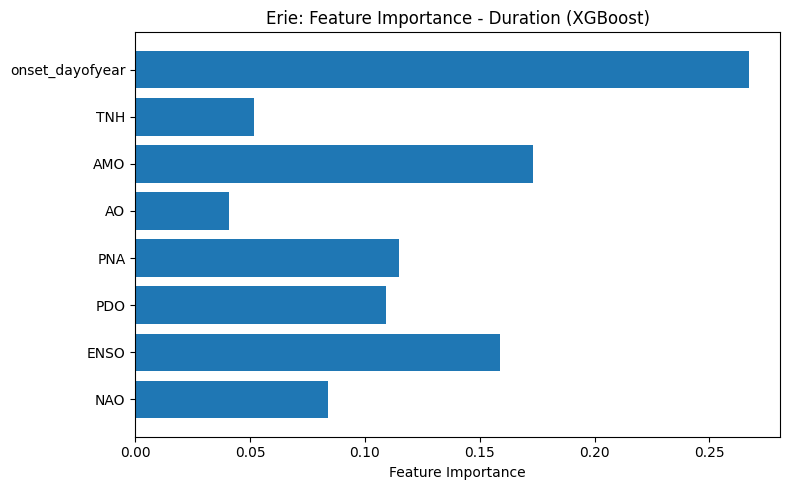


=== Basin - XGBoost Duration Class Prediction ===
              precision    recall  f1-score   support

        Long       0.88      1.00      0.93         7
      Medium       1.00      0.33      0.50         3
       Short       0.67      1.00      0.80         2

    accuracy                           0.83        12
   macro avg       0.85      0.78      0.74        12
weighted avg       0.87      0.83      0.80        12



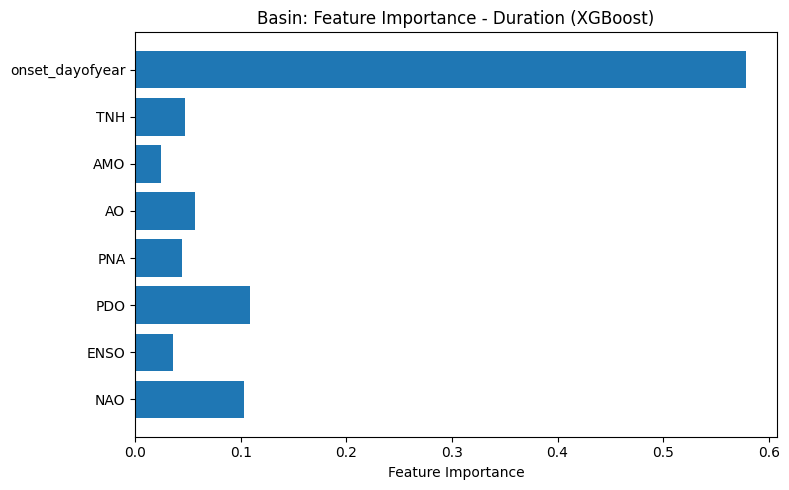

In [ ]:
# XGBoost Model - Duration Prediction (Short, Medium, Long Classes) - All lakes

# Initialize results storage
lake_results_xgb_duration = {}

df_tele['WinterYear'] = np.where(df_tele['Month'] == 1, df_tele['Year'], df_tele['Year'] + 1)
winter_months = df_tele[df_tele['Month'].isin([11, 12, 1])]
winter_avg = winter_months.groupby('WinterYear')[
    ['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH']
].mean().reset_index().rename(columns={'WinterYear': 'Year'})


# Loop through lakes
for lake in lakes:
    lake_df = long_df[long_df['Lake'] == lake].copy()

    def compute_duration(group):
        threshold_days = group[group['IceCover'] >= 5]
        if threshold_days.empty:
            return pd.Series({'ice_duration_days': 0})
        start = threshold_days['Date'].min()
        end = threshold_days['Date'].max()
        duration = (end - start).days + 1
        return pd.Series({'ice_duration_days': duration})

    def get_onset_day(group):
        onset = group[group['IceCover'] >= 5]['Date'].min()
        if pd.isna(onset):
            return pd.Series({'onset_dayofyear': np.nan})
        return pd.Series({'onset_dayofyear': onset.dayofyear})

    ice_durations = lake_df.groupby('Year').apply(compute_duration).reset_index()
    onsets = lake_df.groupby('Year').apply(get_onset_day).reset_index()

    model_df = (
        ice_durations
        .merge(onsets, on='Year')
        .merge(winter_avg, on='Year')
        .dropna()
    )

    if len(model_df) < 10:
        print(f"Skipping {lake}: Not enough data")
        continue

    model_df['duration_class'] = model_df['ice_duration_days'].apply(classify_duration)

    features = ['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH', 'onset_dayofyear']
    X = model_df[features]
    y = model_df['duration_class']

    # Encode categorical labels into numeric
    le = LabelEncoder()
    y = le.fit_transform(model_df['duration_class'])


    # Check class counts
    if np.min(np.bincount(y)) < 2:
        print(f"Skipping {lake}: Not enough samples in one or more classes to split.")
        continue

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42)


    # apply SMOTE
    if len(np.unique(y_train)) > 1:
        smote = SMOTE(random_state=42, k_neighbors=1)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    # Train model
    model_d_xgb = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        learning_rate=0.1,
        n_estimators=100,
        max_depth=4,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    model_d_xgb.fit(X_train_resampled, y_train_resampled)
    y_pred = model_d_xgb.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)

    # Store results
    lake_results_xgb_duration[lake] = {
        'model': model_d_xgb,
        'classification_report': report,
        'feature_importances': dict(zip(features, model_d_xgb.feature_importances_))
    }

    # Report
    print(f"\n=== {lake} - XGBoost Duration Class Prediction ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # # Confusion Matrix
    # ConfusionMatrixDisplay.from_estimator(model_d_xgb, X_test, y_test, display_labels=le.classes_)
    # plt.title(f"Confusion Matrix - {lake} Duration Class (XGBoost + SMOTE)")
    # plt.tight_layout()
    # plt.show()

    # Feature importance
    importances = model_d_xgb.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.barh(features, importances)
    plt.xlabel("Feature Importance")
    plt.title(f"{lake}: Feature Importance - Duration (XGBoost)")
    plt.tight_layout()
    plt.show()



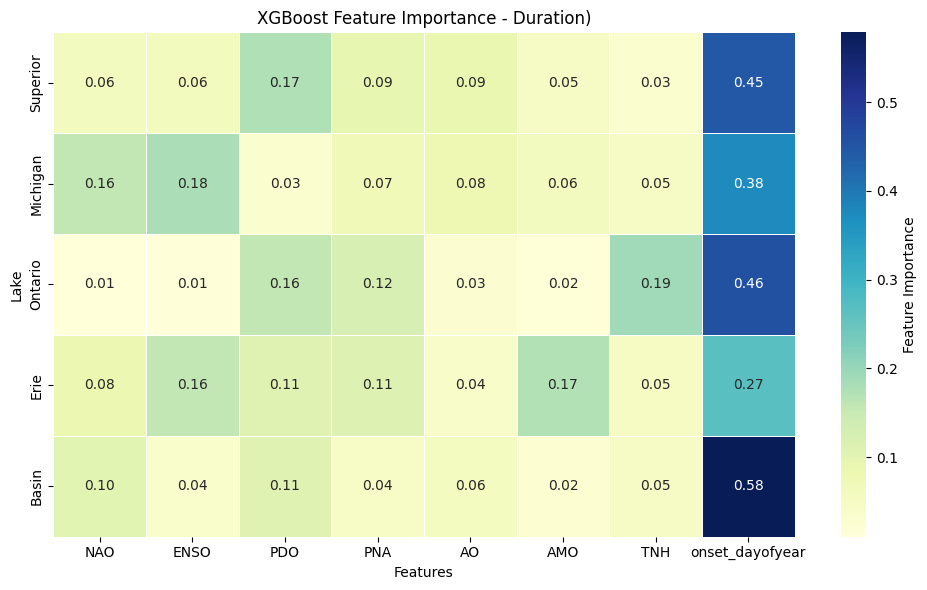

In [ ]:
# XGBoost Model Duration Prediction Heatmap of Feature Importance

# Convert to DataFrame
importance_df = pd.DataFrame({
    lake: data['feature_importances']
    for lake, data in lake_results_xgb_duration.items()
}).T

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    importance_df,
    annot=True,
    cmap='YlGnBu',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Feature Importance'}
)
plt.title("XGBoost Feature Importance - Duration)")
plt.xlabel("Features")
plt.ylabel("Lake")
plt.tight_layout()
plt.show()

### Ensemble Model

In [ ]:
# Ensemble Model - Onset Prediction

# Initialize ensemble
lake_results_ensemble_precise = {}
lake_results_ensemble_5day = {}
lake_results_ensemble_10day = {}

onset_types = [
    ('precise', 'Exact Onset', lake_results_precise, lake_results_xgb_precise, lake_results_lstm_precise, lake_results_ensemble_precise),
    ('5day', '5-Day Onset', lake_results_5day, lake_results_xgb_5day, lake_results_lstm_5day, lake_results_ensemble_5day),
    ('10day', '10-Day Onset', lake_results_10day, lake_results_xgb_10day, lake_results_lstm_10day, lake_results_ensemble_10day)
]

# Loop through onset types
for label, label_name, rf_results, xgb_results, lstm_results, ensemble_results in onset_types:
    for lake in lakes:

        if lake not in rf_results or lake not in xgb_results or lake not in lstm_results:
            print(f"Skipping {lake} - {label_name}: Missing models")
            continue

        # Load teleconnection predictors
        lake_df = long_df[long_df['Lake'] == lake].copy()
        df = pd.merge(lake_df, df_tele.drop(columns=['Date']), on=['Year', 'Month'], how='left')
        df = df.groupby('Year').apply(label_exact_onset).reset_index(drop=True)

        features = ['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH']

        if label == 'precise':
          target = 'onset_exact'
        elif label == '5day':
          target = 'onset_5day'
        elif label == '10day':
          target = 'onset_10day'

        if target not in df.columns:
            print(f"Skipping {lake} - {label_name}: Target not found")
            continue

        df = df.dropna(subset=features + [target])

        X = df[features].values
        y = df[target].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

        # Get predictions
        rf_model = rf_results[lake]['model']
        xgb_model = xgb_results[lake]['model']
        lstm_model = lstm_results[lake]['model']

        rf_pred = rf_model.predict(X_test)
        xgb_pred = xgb_model.predict(X_test)
        X_test_lstm = np.zeros((X_test.shape[0], seq_len, X_test.shape[1]))
        for i in range(seq_len):
            X_test_lstm[:, i, :] = X_test
        lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype(int).flatten()

        # Majority voting
        preds = np.vstack([rf_pred, xgb_pred, lstm_pred])
        ensemble_pred, _ = stats_mode(preds, axis=0)
        ensemble_pred = ensemble_pred.flatten()

        # Classification report
        report = classification_report(y_test, ensemble_pred, output_dict=True)
        print(f"\n=== {lake} - Ensemble {label_name} ===")
        print(classification_report(y_test, ensemble_pred))

        # Save results
        ensemble_results[lake] = {
            'classification_report': report,
            'model': 'Ensemble (RF + XGB + LSTM)',
            'feature_importances': "N/A"
        }

        # # Plot confusion matrix
        # ConfusionMatrixDisplay.from_predictions(y_test, ensemble_pred)
        # plt.title(f"Confusion Matrix - {lake} {label_name} (Ensemble)")
        # plt.tight_layout()
        # plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Superior - Ensemble Exact Onset ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1779
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1791
   macro avg       0.50      0.50      0.50      1791
weighted avg       0.99      0.99      0.99      1791

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Michigan - Ensemble Exact Onset ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1779
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1791
   macro avg       0.50      0.50      0.50      1791
weighted avg       0.99      0.99      0.99      1791

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Huron - Ensemble Exact Onset ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1779


In [ ]:
# Ensemble Model - Duration

# Initialize result storage
lake_results_ensemble_duration = {}

# Loop through lakes
for lake in lakes:

    # Check if all models exist
    if lake not in lake_results_duration or lake not in lake_results_xgb_duration or lake not in lake_results_lstm_duration:
        print(f"Skipping {lake} - Duration Ensemble: Missing models")
        continue

    # Load lake dataframe and merge teleconnections
    lake_df = long_df[long_df['Lake'] == lake].copy()
    df_tele['WinterYear'] = np.where(df_tele['Month'] == 1, df_tele['Year'], df_tele['Year'] + 1)
    winter_months = df_tele[df_tele['Month'].isin([11, 12, 1])]
    winter_avg = winter_months.groupby('WinterYear')[['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH']].mean().reset_index().rename(columns={'WinterYear': 'Year'})

    # helper functions
    def compute_duration(group):
        threshold_days = group[group['IceCover'] >= 5]
        if threshold_days.empty:
            return pd.Series({'ice_duration_days': 0})
        start = threshold_days['Date'].min()
        end = threshold_days['Date'].max()
        duration = (end - start).days + 1
        return pd.Series({'ice_duration_days': duration})

    def get_onset_day(group):
        onset = group[group['IceCover'] >= 5]['Date'].min()
        if pd.isna(onset):
            return pd.Series({'onset_dayofyear': np.nan})
        return pd.Series({'onset_dayofyear': onset.dayofyear})

    ice_durations = lake_df.groupby('Year').apply(compute_duration).reset_index()
    onsets = lake_df.groupby('Year').apply(get_onset_day).reset_index()

    model_df = ice_durations.merge(onsets, on='Year').merge(winter_avg, on='Year').dropna()
    model_df['duration_class'] = model_df['ice_duration_days'].apply(classify_duration)

    if len(model_df) < 10:
        print(f"Skipping {lake} - Not enough data")
        continue

    features = ['NAO', 'ENSO', 'PDO', 'PNA', 'AO', 'AMO', 'TNH', 'onset_dayofyear']
    X = model_df[features].values
    y = model_df['duration_class'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    # Get predictions
    rf_model = lake_results_duration[lake]['model']
    xgb_model = lake_results_xgb_duration[lake]['model']
    lstm_model = lake_results_lstm_duration[lake]['model']

    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)

    # LSTM prediction
    X_test_lstm = np.zeros((X_test.shape[0], seq_len, X_test.shape[1]))
    for i in range(seq_len):
        X_test_lstm[:, i, :] = X_test

    lstm_pred = lstm_model.predict(X_test_lstm)
    lstm_pred = np.argmax(lstm_pred, axis=1)

    #  Prepare voting
    mapping = {"Short": 0, "Medium": 1, "Long": 2, 0: 0, 1: 1, 2: 2}
    inverse_mapping = {0: "Short", 1: "Medium", 2: "Long"}

    rf_pred_int = np.array([mapping[v] for v in rf_pred])
    xgb_pred_int = np.array([mapping[v] for v in xgb_pred])

    preds = np.vstack([rf_pred_int, xgb_pred_int, lstm_pred])

    # Ensemble majority vote
    ensemble_pred, _ = stats_mode(preds, axis=0)
    ensemble_pred = ensemble_pred.flatten()

    # Convert back to labels
    ensemble_pred_labels = np.array([inverse_mapping[v] for v in ensemble_pred])

    # Report
    report = classification_report(y_test, ensemble_pred_labels, output_dict=True)
    print(f"\n=== {lake} - Ensemble Duration ===")
    print(classification_report(y_test, ensemble_pred_labels))

    # Save results
    lake_results_ensemble_duration[lake] = {
        'classification_report': report,
        'model': 'Ensemble (RF + XGB + LSTM)',
        'feature_importances': "N/A"
    }

    # # Plot confusion matrix
    # ConfusionMatrixDisplay.from_predictions(y_test, ensemble_pred_labels)
    # plt.title(f"Confusion Matrix - {lake} Duration (Ensemble)")
    # plt.tight_layout()
    # plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

=== Superior - Ensemble Duration ===
              precision    recall  f1-score   support

        Long       0.00      0.00      0.00         6
      Medium       0.00      0.00      0.00         3
       Short       0.14      0.33      0.20         3

    accuracy                           0.08        12
   macro avg       0.05      0.11      0.07        12
weighted avg       0.04      0.08      0.05        12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

=== Michigan - Ensemble Duration ===
              precision    recall  f1-score   support

        Long       0.33      0.17      0.22         6
      Medium       0.40      0.50      0.44         4
       Short       0.00      0.00      0.00         2

    accuracy                           0.25        12
   macro avg       0.24      0.22      0.22        12
weighted avg       0.30      0.25      0.26        12

Skipping Huron - Duration Ensemble: Missing models
Skipping Ontario - Duration Ensembl

### Model Accuracy and Error Metrics

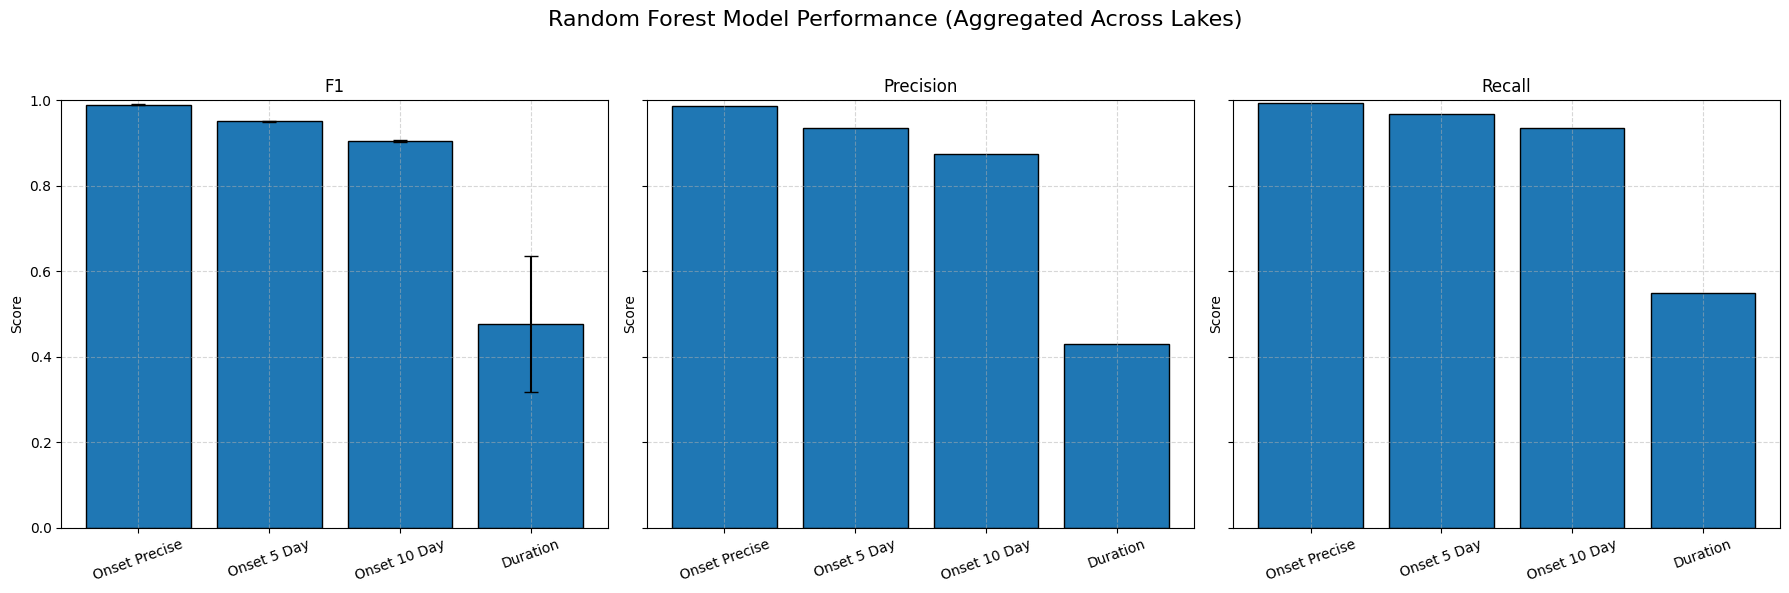

In [ ]:
# Random Forests Model Performance

# Classification report dictionaries
results_precise = lake_results_precise  # dict
results_5day = lake_results_5day
results_10day = lake_results_10day
results_duration = lake_results_duration

# Group for processing
all_results = {
    "Onset Precise": results_precise,
    "Onset 5 Day": results_5day,
    "Onset 10 Day": results_10day,
    "Duration": results_duration,
}

# Prepare summary
model_summary = {}

for model_name, lake_results in all_results.items():
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for lake, result in lake_results.items():
        report = result["classification_report"]

        # weighted avg scores
        f1 = report['weighted avg']['f1-score']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']

        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

    # Aggregate
    model_summary[model_name] = {
        "F1": np.mean(f1_scores),
        "F1_std": np.std(f1_scores),
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores)
    }

# Convert to dataframe
df_summary = pd.DataFrame(model_summary).T
df_summary['Model'] = df_summary.index

# Plot
metrics = ['F1', 'Precision', 'Recall']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Random Forest Model Performance (Aggregated Across Lakes)", fontsize=16)

for ax, metric in zip(axes, metrics):
    ax.bar(df_summary['Model'], df_summary[metric], yerr=df_summary['F1_std'] if metric == 'F1' else None, capsize=5, edgecolor='black')
    ax.set_ylim(0, 1)
    ax.set_title(metric)
    ax.set_ylabel("Score")
    ax.set_xticklabels(df_summary['Model'], rotation=20)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


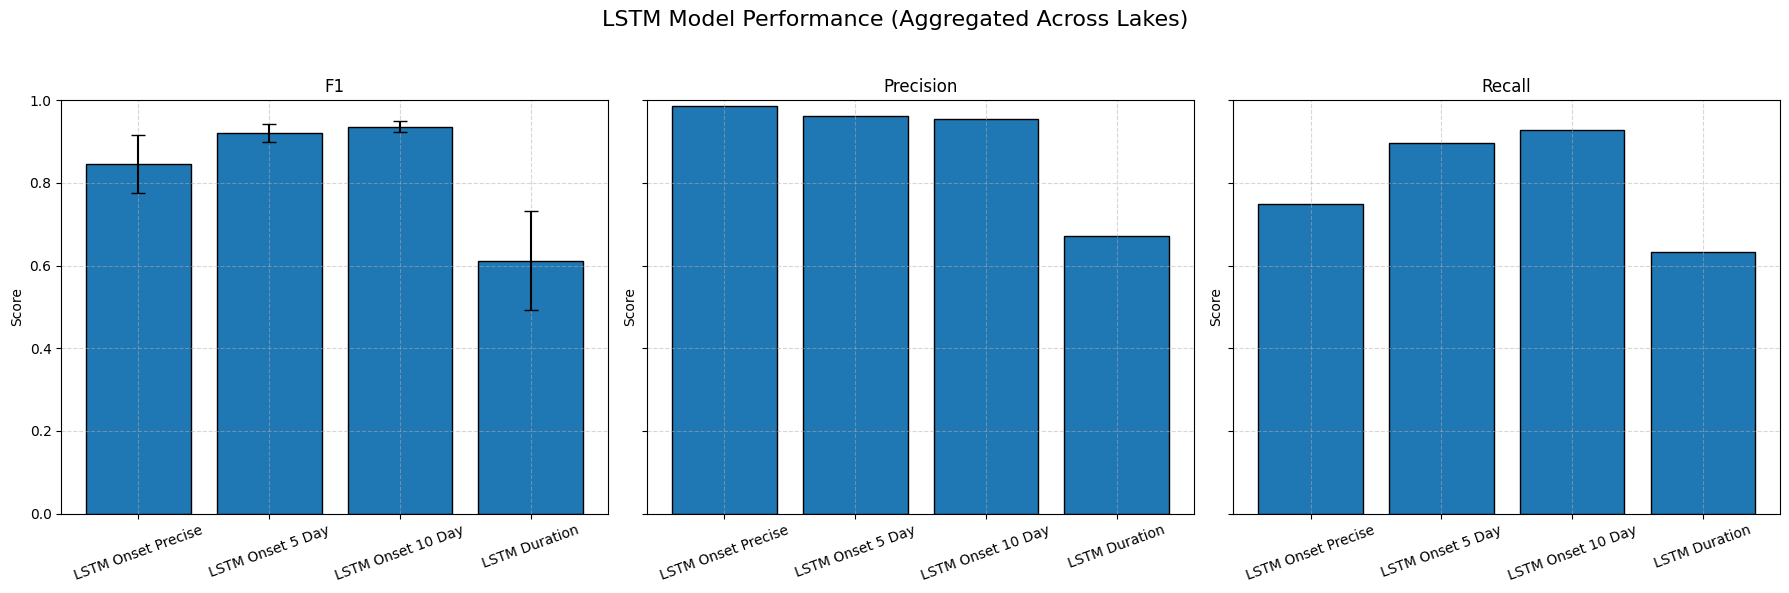

In [ ]:
# LSTM Model Performance

# Define all LSTM model results
all_results = {
    "LSTM Onset Precise": lake_results_lstm_precise,
    "LSTM Onset 5 Day": lake_results_lstm_5day,
    "LSTM Onset 10 Day": lake_results_lstm_10day,
    "LSTM Duration": lake_results_lstm_duration
}

# Prepare summary dictionary
model_summary = {}

for model_name, lake_results in all_results.items():
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for lake, result in lake_results.items():
        report = result["classification_report"]

        f1 = report['weighted avg']['f1-score']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']

        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

    model_summary[model_name] = {
        "F1": np.mean(f1_scores) if f1_scores else 0,
        "F1_std": np.std(f1_scores) if f1_scores else 0,
        "Precision": np.mean(precision_scores) if precision_scores else 0,
        "Recall": np.mean(recall_scores) if recall_scores else 0
    }

# Convert DataFrame
df_summary = pd.DataFrame(model_summary).T
df_summary["Model"] = df_summary.index

# Plot
metrics = ["F1", "Precision", "Recall"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("LSTM Model Performance (Aggregated Across Lakes)", fontsize=16)

for ax, metric in zip(axes, metrics):
    ax.bar(df_summary["Model"], df_summary[metric],
           yerr=df_summary["F1_std"] if metric == "F1" else None,
           capsize=5, edgecolor='black')

    ax.set_ylim(0, 1)
    ax.set_title(metric)
    ax.set_ylabel("Score")
    ax.set_xticks(np.arange(len(df_summary["Model"])))
    ax.set_xticklabels(df_summary["Model"], rotation=20)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


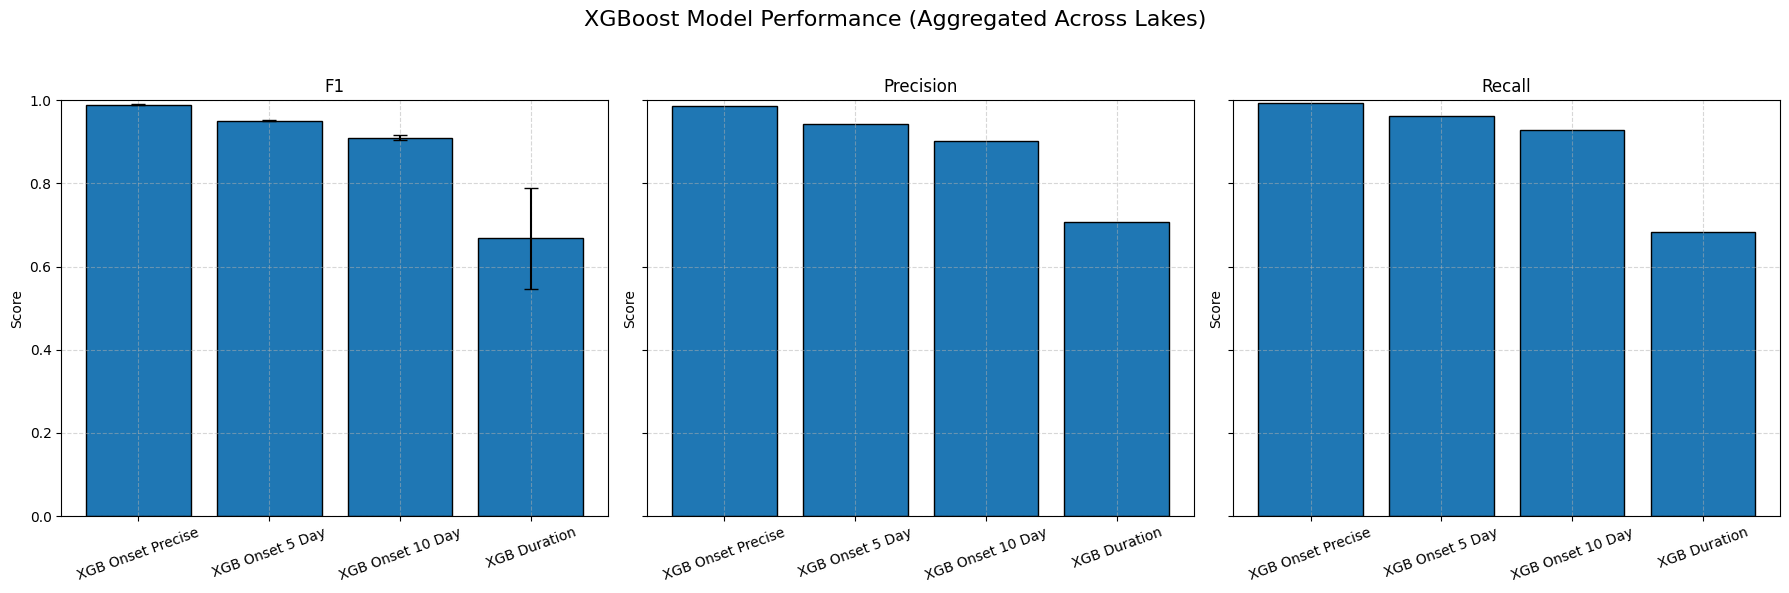

In [ ]:
# XGBoost Model Performance

# Collect all model result dicts
all_results = {
    "XGB Onset Precise": lake_results_xgb_precise,
    "XGB Onset 5 Day": lake_results_xgb_5day,
    "XGB Onset 10 Day": lake_results_xgb_10day,
    "XGB Duration": lake_results_xgb_duration
}

# Prepare summary dictionary
model_summary = {}

for model_name, lake_results in all_results.items():
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for lake, result in lake_results.items():
        report = result["classification_report"]

        # weighted average scores
        f1 = report['weighted avg']['f1-score']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']

        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

    # Aggregate
    model_summary[model_name] = {
        "F1": np.mean(f1_scores),
        "F1_std": np.std(f1_scores),
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores)
    }

# Convert to DataFrame
df_summary = pd.DataFrame(model_summary).T
df_summary["Model"] = df_summary.index

# Plot
metrics = ["F1", "Precision", "Recall"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("XGBoost Model Performance (Aggregated Across Lakes)", fontsize=16)

for ax, metric in zip(axes, metrics):
    ax.bar(df_summary["Model"], df_summary[metric],
           yerr=df_summary["F1_std"] if metric == "F1" else None,
           capsize=5, edgecolor='black')

    ax.set_ylim(0, 1)
    ax.set_title(metric)
    ax.set_ylabel("Score")
    ax.set_xticklabels(df_summary["Model"], rotation=20)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


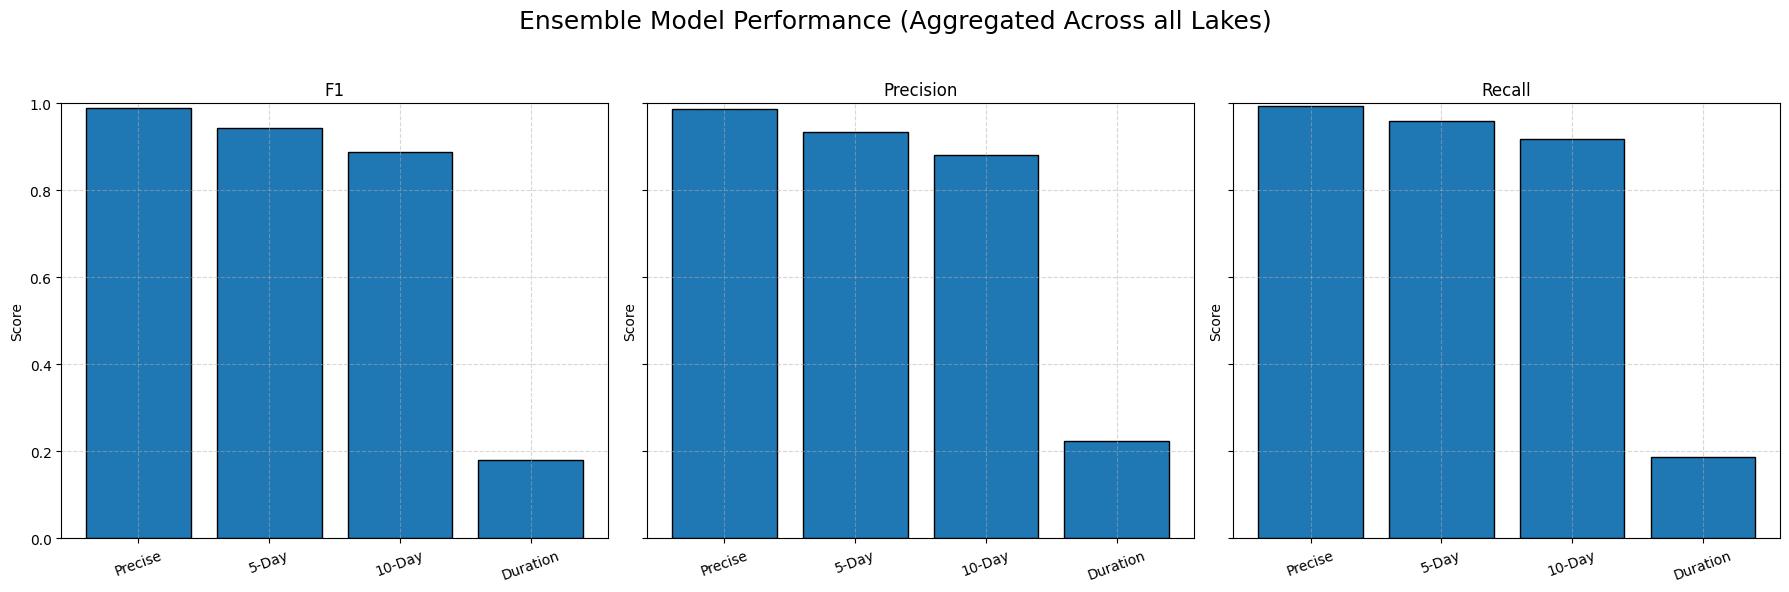

In [ ]:
# Ensemble Model Performance

ensemble_results = {
    'Precise': lake_results_ensemble_precise,
    '5-Day': lake_results_ensemble_5day,
    '10-Day': lake_results_ensemble_10day,
    'Duration': lake_results_ensemble_duration
}

# F1, Precision, Recall
summary = {'Model': [], 'F1': [], 'Precision': [], 'Recall': []}

for model_name, result_dict in ensemble_results.items():
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for lake, result in result_dict.items():
        report = result['classification_report']

        f1_scores.append(report['weighted avg']['f1-score'])
        precision_scores.append(report['weighted avg']['precision'])
        recall_scores.append(report['weighted avg']['recall'])

    summary['Model'].append(model_name)
    summary['F1'].append(np.mean(f1_scores))
    summary['Precision'].append(np.mean(precision_scores))
    summary['Recall'].append(np.mean(recall_scores))

# DataFrame
df_summary = pd.DataFrame(summary)

# Plot
metrics = ['F1', 'Precision', 'Recall']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Ensemble Model Performance (Aggregated Across all Lakes)", fontsize=18)

for ax, metric in zip(axes, metrics):
    ax.bar(df_summary['Model'], df_summary[metric], edgecolor='black')
    ax.set_ylim(0, 1)
    ax.set_title(metric)
    ax.set_ylabel("Score")
    ax.set_xticklabels(df_summary["Model"], rotation=20)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# Model Performance Metrics Table

models = {
    "Random Forest": {
        "Precise": lake_results_precise,
        "5 Day": lake_results_5day,
        "10 Day": lake_results_10day,
        "Duration": lake_results_duration,
    },
    "XGBoost": {
        "Precise": lake_results_xgb_precise,
        "5 Day": lake_results_xgb_5day,
        "10 Day": lake_results_xgb_10day,
        "Duration": lake_results_xgb_duration,
    },
    "LSTM": {
        "Precise": lake_results_lstm_precise,
        "5 Day": lake_results_lstm_5day,
        "10 Day": lake_results_lstm_10day,
        "Duration": lake_results_lstm_duration,
    }
}

records = []

# Loop through all models
for model_name, model_results in models.items():
    for task, lakes_results in model_results.items():
        for lake, result in lakes_results.items():
            report = result["classification_report"]["weighted avg"]

            record = {
                "Lake": lake,
                "Model": model_name,
                "Task": task,
                "Precision": report["precision"],
                "Recall": report["recall"],
                "F1": report["f1-score"]
            }
            records.append(record)

# Create dataframe
df_results = pd.DataFrame(records)

# cleaner format
pivot_df = df_results.pivot_table(index=["Lake", "Model"],
                                  columns="Task",
                                  values=["Precision", "Recall", "F1"])

# Flatten column hierarchy
pivot_df.columns = [f"{metric} - {task}" for metric, task in pivot_df.columns]

# Reset index
pivot_df = pivot_df.reset_index()

# Display table
pd.set_option('display.max_columns', None)
print(pivot_df)


        Lake          Model  F1 - 10 Day  F1 - 5 Day  F1 - Duration  \
0      Basin           LSTM     0.953210    0.894530       0.633700   
1      Basin  Random Forest     0.903113    0.950862       0.533333   
2      Basin        XGBoost     0.903113    0.950862       0.802778   
3       Erie           LSTM     0.919481    0.894948       0.800824   
4       Erie  Random Forest     0.903113    0.950862       0.429825   
5       Erie        XGBoost     0.907448    0.950862       0.729396   
6      Huron           LSTM     0.943121    0.939858            NaN   
7      Huron  Random Forest     0.903113    0.950862       0.333333   
8      Huron        XGBoost     0.903113    0.950862            NaN   
9   Michigan           LSTM     0.944218    0.947483       0.594444   
10  Michigan  Random Forest     0.903113    0.950862       0.757576   
11  Michigan        XGBoost     0.916209    0.950424       0.562393   
12   Ontario           LSTM     0.917928    0.913348       0.604575   
13   O